# Project 2 - Dynamic Programming

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Presets across all senarios
allow_no_coach_sale=False # For scenario 3
seasonal_demand=False    # For scenario 4
coach_seats=100          # Fixed across all scenarios
first_class_seats=20     # Fixed across all scenarios
coach_prices=[300, 350]  # Fixed across all scenarios
first_class_prices=[425, 500] # Fixed across all scenarios
coach_show_prob=0.95    # Fixed across all scenarios 
first_class_show_prob=0.97 # Fixed across all scenarios
coach_demand_prob=[0.65, 0.30] # Base probabilities
coach_demand_increase=0.03 # Coach demand increase when first-class sold out
first_class_demand_prob=[0.08, 0.04] # Base probabilities
bump_cost=50             # Cost to bump to first-class
denied_cost=425          # Cost to deny boarding
days=365                 # days until flight
discount_rate=0.17       # used to discount profit from selling tickets at time t

## Scenario 1:
### Given:
- 365 days until plane departs
- 100 seats in coach and 20 seats in first class
- Show passengers
    - P(first-class passenger shows) = .97
    - P(coach passenger shows) = .95
- Ticket prices:
    - Coach = \$300 or \$350
    - First = \$425 or \$500
- Ticket demand:
    - Can sell 0 or 1 tickets for each class each day
    - Demand for coach and first-class independent
    - If there is more demand for first-class than there are tickets, customers won't buy a coach seat.
    - If there is more demand for coach than there are tickets, customers won't buy a first-class seat.
    - Coach
        - If price = \$300, then P(sale) = .65
        - If price = \$350, then P(sale) = .3
        - If first class is sold out and price = \$300, P(sale) = .68
        - If first class is sold out and price = $\350, P(sale) = .33
    - First
        - If price = \$425, then P(sale) = .08
        - If price = \$500, the P(sale) = .04
- Overbooking costs:
    - Coach is allowed to be oversold by 5 seats
    - Not allowed to overbook first class
    - \$50 to bump coach passengr to first class
    - \$425 to bump coach passenger off flight
- Discount factor
    - yearly $\delta = \frac{1}{.17}$
    - daily $\delta = \frac{1}{1+0.17/365}$
- Terminal condition
    - On the day the flight takes off, there is no revenue, only costs.

### Defining the dynamic program:

#### State variables
- State = (t, $c_t$, $f_t$)
- t = day (0,1,...,365)
- $c_t$ = total coach tickets sold at time t
- $f_t$ = total first class tickets sold at time t

#### Choice variables
- On each day you have 4 choices:
    - Coach price = \$300 or \$350
    - First-class price = \$425 or \$500
- This gives you 4 possible combinations each day:
    - (300, 425): low coach price, low first-class price
    - (300, 500): low coach price, high first-class price
    - (350, 425): high coach price, low first-class price
    - (350, 500): high coach price, high first-class price

#### Dynamics
- (t, $c_t$, $f_t$) ------> (t+1, $c_{t+1}$, $f_{t+1}$)
- Can sell either 0 or 1 coach tickets
- Can sell either 0 or 1 first-class tickets
- Number of tickets sold at time t+1 is dependent on the price chosen at time t:

$$
\text{Coach tickets sold at } t+1: \\
c_{t+1} = 
\begin{cases}
c_t + 1, & \text{with probability } P_c(p_c, f_t) \text{ if } c_t < \text{cap}_c \\
c_t, & \text{with probability } (1 - P_c(p_c, f_t)) \text{ or if } c_t = \text{cap}_c
\end{cases}
$$

$$
\text{First-class tickets sold at } t+1: \\
f_{t+1} = 
\begin{cases}
f_t + 1, & \text{with probability } P_f(p_f) \text{ if } f_t < 20 \\
f_t, & \text{with probability } (1 - P_f(p_f)) \text{ or if } f_t = 20
\end{cases}
$$

Where:
- $c_t$ = Number of coach tickets sold at time $t$
- $f_t$ = Number of first-class tickets sold at time $t$
- $c_{t+1}$ = Number of coach tickets sold at time $t+1$
- $f_{t+1}$ = Number of first-class tickets sold at time $t+1$
- $\text{cap}_c$ = Maximum allowed coach tickets (105 for the +5 oversold scenario)
- $p_c$ = Price of coach ticket, either $\$300$ or $\$350$
- $p_f$ = Price of first-class ticket, either $\$425$ or $\$500$
- $P_c(p_c, f_t)$ = Probability of selling a coach ticket at price $p_c$ given $f_t$ first-class tickets sold:
  * $P_c(300, f_t) = 0.65$ if $f_t < 20$, and $0.68$ if $f_t = 20$
  * $P_c(350, f_t) = 0.30$ if $f_t < 20$, and $0.33$ if $f_t = 20$
- $P_f(p_f, c_t)$ = Probability of selling a first-class ticket at price $p_f$:
  * $P_f(425) = 0.08$ 
  * $P_f(500) = 0.04$ 

#### Bellman equation
$$
V(t, c_t, f_t) = \max_{p_c, p_f} \{ \mathbb{E}[R_t + \delta \cdot V(t+1, c_{t+1}, f_{t+1})] \}
$$

Where:
- $V(t, c_t, f_t)$ = Maximum expected discounted profit from state $(t, c_t, f_t)$
- $c_t$ = Number of coach tickets sold at time $t$
- $f_t$ = Number of first-class tickets sold at time $t$
- $p_c$ = Price of coach ticket, either $\$300$ or $\$350$
- $p_f$ = Price of first-class ticket, either $\$425$ or $\$500$
- $R_t$ = Revenue at time $t$
- $\delta$ = Daily discount factor = $1/(1+0.17/365)$

We can expand the expectation by considering all possible combinations of ticket sales:

$$
V(t, c_t, f_t) = \max_{p_c, p_f} \left\{ 
\begin{aligned}
&P_c(p_c, f_t) \cdot P_f(p_f, c_t) \cdot [p_c + p_f + \delta \cdot V(t+1, c_t+1, f_t+1)] + \\
&P_c(p_c, f_t) \cdot (1-P_f(p_f, c_t)) \cdot [p_c + \delta \cdot V(t+1, c_t+1, f_t)] + \\
&(1-P_c(p_c, f_t)) \cdot P_f(p_f, c_t) \cdot [p_f + \delta \cdot V(t+1, c_t, f_t+1)] + \\
&(1-P_c(p_c, f_t)) \cdot (1-P_f(p_f, c_t)) \cdot [\delta \cdot V(t+1, c_t, f_t)]
\end{aligned}
\right\}
$$

With boundary conditions:
- If $c_t = \text{cap}_c$, then no more coach tickets can be sold
- If $f_t = 20$, then no more first-class tickets can be sold

##### Expanded Bellman Equation for All Price Combinations

We can further expand the Bellman equation to explicitly show all four pricing combination choices:

Let's denote the four pricing combinations as:
1. $(p_c, p_f) = (300, 425)$: Low coach price, low first-class price
2. $(p_c, p_f) = (300, 500)$: Low coach price, high first-class price
3. $(p_c, p_f) = (350, 425)$: High coach price, low first-class price
4. $(p_c, p_f) = (350, 500)$: High coach price, high first-class price

Then the Bellman equation becomes:

$$
V(t, c_t, f_t) = \max \left\{ V^{(300,425)}(t, c_t, f_t), V^{(300,500)}(t, c_t, f_t), V^{(350,425)}(t, c_t, f_t), V^{(350,500)}(t, c_t, f_t) \right\}
$$

Where each pricing strategy's value is:

$$
V^{(300,425)}(t, c_t, f_t) = 
\begin{aligned}
&P_c(300, f_t) \cdot P_f(425) \cdot [300 + 425 + \delta \cdot V(t+1, c_t+1, f_t+1)] + \\
&P_c(300, f_t) \cdot (1-P_f(425)) \cdot [300 + \delta \cdot V(t+1, c_t+1, f_t)] + \\
&(1-P_c(300, f_t)) \cdot P_f(425) \cdot [425 + \delta \cdot V(t+1, c_t, f_t+1)] + \\
&(1-P_c(300, f_t)) \cdot (1-P_f(425)) \cdot [\delta \cdot V(t+1, c_t, f_t)]
\end{aligned}
$$

Similar equations apply for the other three price combinations, with the appropriate price values substituted.

The probability values from the problem statement are:
- $P_c(300, f_t) = 0.65$ if $f_t < 20$, and $0.68$ if $f_t = 20$
- $P_c(350, f_t) = 0.30$ if $f_t < 20$, and $0.33$ if $f_t = 20$
- $P_f(425) = 0.08$
- $P_f(500) = 0.04$

With constraints applied when tickets are sold out:
- If $c_t = \text{cap}_c$, then $P_c(300, f_t) = P_c(350, f_t) = 0$
- If $f_t = 20$, then $P_f(425) = P_f(500) = 0$

This formulation allows us to systematically compute the expected value for each pricing strategy at every state and choose the optimal policy.

#### Terminal Condition (t = 365)
At t = 365 (day of flight departure), there are no more sales opportunities, and we only need to account for the expected overbooking costs:

$$
V(365, c_{365}, f_{365}) = -\mathbb{E}[\text{Overbooking costs}]
$$

This expectation can be expanded using the properties of expectations and binomial probability distributions:

$$
V(365, c_{365}, f_{365}) = -\sum_{i=0}^{c_{365}} \sum_{j=0}^{f_{365}} P(C=i) \cdot P(F=j) \cdot \text{Cost}(i, j)
$$

Where:
- $C$ = Number of coach passengers who show up (binomial with probability 0.95)
- $F$ = Number of first-class passengers who show up (binomial with probability 0.97)
- $P(C=i) = \binom{c_{365}}{i}(0.95)^i(0.05)^{c_{365}-i}$ 
- $P(F=j) = \binom{f_{365}}{j}(0.97)^j(0.03)^{f_{365}-j}$
- $\text{Cost}(i, j)$ = Overbooking cost for $i$ coach show-ups and $j$ first-class show-ups

The cost function is defined as:

$$
\text{Cost}(i, j) = 
\begin{cases}
0, & \text{if } i \leq 100 \\
50 \cdot \min(i-100, 20-j), & \text{if } 100 < i \leq 100 + (20-j) \\
50 \cdot (20-j) + 425 \cdot (i - 100 - (20-j)), & \text{if } i > 100 + (20-j)
\end{cases}
$$

This cost function accounts for the three possible scenarios:
1. Coach show-ups don't exceed capacity (100 seats) → No cost
2. Some coach passengers can be bumped to available first-class seats → $\$50$ per passenger
3. After filling available first-class seats, additional passengers must be denied boarding → $\$425$ per passenger

This terminal condition provides the base case for our forward dynamic programming solution process, starting from t = 1 and progressing to t = 365.


## Scenario 2
Same as scenario 1, except coach can be oversold by 6,7,8,...,15 seats.

Which overbooking policy leads to the largest profits by the airline?

## Scenario 3
Now assume that the airline can choose not to sell coach tickets on any given day, meaning there are 3 options for coach tickets each day: low price, high price, or no sale. There are still only two choices for first class: low or high price.

The airline will never sell more than 120 seats in coach, but on any one day they can choose to not sell coach tickets. This way they can stop over-selling tickets not just based on how many they have sold, but also on how many days are left to sell.

Does this policy have a better or worse expected profit than the best policy from step 2?

## Scenario 4
Now assume that as the time of departure gets closer, the demand for tickets increases. This is like seasonality. On each day t, for each ticket class, multiply the probability of a sale by $0.75 + t/730$. For example, on day t = 100 if you charge \$300 for a seat in coach and then the probability of a sale is 57.65% instead of 65%.

## Scenario 5
Now that you have solved the problem backwards, use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of discounted profits? Are there any other interesting questions you can think of? Make a few graphs to examine these questions. Do this for both policies above.

In [2]:
# Can calculate expected profit for any of the scenarios above using this function
def calculate_expected_profit(
    overbooking_level,        # Coach seats that can be overbooked
    allow_no_coach_sale=False, # Change for scenario 3
    seasonal_demand=False,    # Change for scenario 4
    # Set defaults for constant variables across scenarios based on presets
    coach_seats=coach_seats,          # Fixed across all scenarios
    first_class_seats=first_class_seats,     # Fixed across all scenarios
    coach_prices=coach_prices,  # Fixed across all scenarios
    first_class_prices=first_class_prices, # Fixed across all scenarios
    coach_show_prob=coach_show_prob,     # Fixed across all scenarios 
    first_class_show_prob=first_class_show_prob, # Fixed across all scenarios
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,          # Cost to deny boarding
    days=days,                 # Fixed across all scenarios
    discount_rate=discount_rate        # Fixed across all scenarios
):
    # Initial state
    t = days  # days until plane departs
    c = 0    # coach tickets sold
    f = 0    # first class tickets sold
    C = coach_seats  # number of coach seats
    F = first_class_seats   # number of first class seats
    delta = 1/(1+discount_rate/days)

    # Choice variables
    p_c = coach_prices 
    p_f = first_class_prices  # first-class prices

    # Dynamics
    P_c = coach_demand_prob  # probability of selling coach ticket at each price
    P_c_adj = np.array(P_c) + coach_demand_increase # coach probability increases if first-class sells out
    P_f = first_class_demand_prob  # probability of selling first-class ticket at each price

    # Terminal condition
    T = days
    c_cap = C + overbooking_level  # coach tickets that can be sold

    # All possible state values
    tValues = np.arange(T+1)  # all possible days until take off (0-365)
    cValues = np.arange(c_cap+1)  # 0 to (100 + overbooking_level) coach tickets sold
    fValues = np.arange(F+1)  # 0-20 first-class tickets sold
    
    # Count possible state values
    tN = len(tValues)  # 366
    cN = len(cValues)  # (101 + overbooking_level)
    fN = len(fValues)  # 21
    
    # Set up V and U matrices
    V = np.zeros((tN, cN, fN))  # 3D matrix 
    U = np.zeros((tN, cN, fN))
    
    # Terminal condition calculation
    for c_T in range(cN):
        for f_T in range(fN):
            exp_cost = 0
            for i in range(c_T + 1):
                for j in range(f_T + 1):
                    P_i = stats.binom.pmf(i, c_T, coach_show_prob)
                    P_j = stats.binom.pmf(j, f_T, first_class_show_prob)
                    if i <= C:  # less coach passengers show up than coach seats available
                        cost = 0
                    elif i <= C + (F - j):  # all extra coach passengers can be bumped to first-class
                        cost = bump_cost * (i - C)
                    else:  # some passengers must be denied boarding
                        cost = bump_cost * (F - j) + denied_cost * (i - C - (F - j))
                    exp_cost += P_i * P_j * cost
            V[tN-1, c_T, f_T] = -exp_cost
    
    # Solve the bellman equation
    for t in reversed(range(tN-1)):  # day 364 to 0
        # set the demand dependent on time if using seasonal demand
        if seasonal_demand:
            P_ct = np.array(P_c) * (.75 + t/730) # demand of coach at time t
            P_ct_adj = np.array(P_c_adj) * (.75 + t/730) # demand of coach at time t if first-class sold out
            P_ft = np.array(P_f) * (.75 + t/730) # demand of first class at time t
        else:
            P_ct = P_c # demand of coach at time t (constant)
            P_ct_adj = P_c_adj # demand of coach at time t if first-class sold out
            P_ft = P_f # demand of first class at time t
        for c in range(cN):  # 0 to (100 + overbooking_level) tickets sold
            for f in range(fN):  # 0 to 20 tickets sold
                if c == c_cap and f<F: # Can't sell more coach tickets, but can sell first-class
                    # Low first-class price
                    valueL = P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + (1-P_ft[0]) * delta * V[t+1, c, f]
                    # High first-class price
                    valueH = P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + (1-P_ft[1]) * delta * V[t+1, c, f]
                    V[t, c, f] = max(valueL, valueH)
                    if allow_no_coach_sale:
                        U[t, c, f] = np.argmax([valueL, valueH]) + 9  # 9 for -L, 10 for -H
                    else:
                        U[t, c, f] = np.argmax([valueL, valueH]) + 6  # 6 for -L, 7 for -H
                
                elif c == c_cap and f == F:  # Both at capacity
                    V[t, c, f] = delta * V[t+1, c, f]
                    if allow_no_coach_sale:
                        U[t, c, f] = 11  # No sale possible
                    else:
                        U[t, c, f] = 8 
                elif c < c_cap and f == F:  # First-class is sold out but coach isn't
                    # Low coach price
                    valueL = P_ct_adj[0] * (p_c[0] + delta * V[t+1, c+1, f]) + (1-P_ct_adj[0]) * delta * V[t+1, c, f]
                    # High coach price
                    valueH = P_ct_adj[1] * (p_c[1] + delta * V[t+1, c+1, f]) + (1-P_ct_adj[1]) * delta * V[t+1, c, f]
                    # No coach
                    valueN = delta * V[t+1, c, f]
                    
                    if allow_no_coach_sale:
                        V[t, c, f] = max(valueL, valueH, valueN)
                        U[t, c, f] = np.argmax([valueL, valueH, valueN]) + 6  # 6 for L-, 7 for H-, 8 for N-
                    else:
                        V[t, c, f] = max(valueL, valueH)
                        U[t, c, f] = np.argmax([valueL, valueH]) + 4  # 4 for L-, 5 for H-
                        
                
                else:  # Both ticket types can potentially be sold
                    # Calculate value for all four (six) price combinations (six combinations when no sale is allowed)
                    
                    # Low coach, Low first-class (LL)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_LL = P_ct[0] * P_ft[0] * (p_c[0] + p_f[0] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[0] * (1-P_ft[0]) * (p_c[0] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[0]) * P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[0]) * (1-P_ft[0]) * delta * V[t+1, c, f]
                    
                    # Low coach, High first-class (LH)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_LH = P_ct[0] * P_ft[1] * (p_c[0] + p_f[1] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[0] * (1-P_ft[1]) * (p_c[0] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[0]) * P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[0]) * (1-P_ft[1]) * delta * V[t+1, c, f]
                    
                    # High coach, Low first-class (HL)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_HL = P_ct[1] * P_ft[0] * (p_c[1] + p_f[0] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[1] * (1-P_ft[0]) * (p_c[1] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[1]) * P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[1]) * (1-P_ft[0]) * delta * V[t+1, c, f]
                    
                    # High coach, High first-class (HH)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_HH = P_ct[1] * P_ft[1] * (p_c[1] + p_f[1] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[1] * (1-P_ft[1]) * (p_c[1] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[1]) * P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[1]) * (1-P_ft[1]) * delta * V[t+1, c, f]

                    # No coach, Low first-class (NL)
                    # expected profit calculate across first-class purchased or not
                    value_NL = P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ft[0]) * delta * V[t+1, c, f]

                    # No coach, High first-class (NH)
                    # expected profit calculate across first-class purchased or not
                    value_NH =  P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ft[1]) * delta * V[t+1, c, f]
                    
                    if allow_no_coach_sale:
                        values = [value_LL, value_LH, value_HL, value_HH, value_NL, value_NH]
                        V[t, c, f] = max(values)
                        U[t, c, f] = np.argmax(values)  # 0 = LL, 1 = LH, 2 = HL, 3 = HH, 4 = NL, 5 = NH
                    else:
                        values = [value_LL, value_LH, value_HL, value_HH]
                        V[t, c, f] = max(values)
                        U[t, c, f] = np.argmax(values)  # 0 = LL, 1 = LH, 2 = HL, 3 = HH

    
    return V[0, 0, 0], V, U  # Return expected profit, value, and optimal decision matrix

# Function to simulate the solution forward once
def simulate_flight(
    U,        # Optimal decisions for each state from output of calculate_expected_profit
    allow_no_coach_sale, # MUST match the value used in calculate_expected_profit
    seasonal_demand,    # Must match the value used in calculate_expected_profit
    # Set defaults for constant variables across scenarios based on presets
    # If you change any of the below parameters in calculate_expected_profit, change here too
    coach_seats=coach_seats,          
    first_class_seats=first_class_seats,     
    coach_prices=coach_prices,  
    first_class_prices=first_class_prices,
    coach_show_prob=coach_show_prob,    
    first_class_show_prob=first_class_show_prob,
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,         # Cost to deny boarding
    days=days,                 
    discount_rate=discount_rate
):
    # Initial state
    t = 0  # days until plane departs
    c = 0    # coach tickets sold
    f = 0    # first class tickets sold
    C = coach_seats  # number of coach seats
    F = first_class_seats   # number of first class seats
    profit = 0
    delta = 1/(1+discount_rate/days)

    # Arrays for tracking
    coach_prices_over_time = []
    first_class_prices_over_time = []
    coach_sales_over_time = []
    first_class_sales_over_time = []
    daily_coach_demand = []
    daily_first_class_demand = []

    # Choice variables
    p_c = coach_prices 
    p_f = first_class_prices  # first-class prices

    # Dynamics
    P_c = coach_demand_prob  # probability of selling coach ticket at each price
    P_c_adj = np.array(P_c) + coach_demand_increase # coach probability increases if first-class sells out
    P_f = first_class_demand_prob  # probability of selling first-class ticket at each price

    # Terminal condition
    T = days
    # Get the overbooking level
    c_cap = U.shape[1] - 1 # coach tickets that can be sold
    
    for t in range(T):  # day 0 to 364 (full days period)
        # Initialize daily tracking variables
        coach_sold_today = 0
        first_class_sold_today = 0
        
        # Set the demand dependent on time if using seasonal demand
        if seasonal_demand:
            P_ct = np.array(P_c) * (.75 + t/730)
            P_ct_adj = np.array(P_c_adj) * (.75 + t/730)
            P_ft = np.array(P_f) * (.75 + t/730)
        else:
            P_ct = P_c
            P_ct_adj = P_c_adj
            P_ft = P_f
        # Determine the price charged and demand for each day depending on the optimal policy
        # No sale is incporated into the U codes, so don't need to worry about the coach cap
        # Consider using a dictionary to make this look better!
        if allow_no_coach_sale:
            if U[t,c,f] == 0: # LL
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 1: # LH
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 2: # HL
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 3: # HH
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 4: # NL
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 5: # NH
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 6: # L-
                p_ct = p_c[0]
                P_ct_val = P_ct_adj[0]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 7: # H-
                p_ct = p_c[1]
                P_ct_val = P_ct_adj[1]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 8: # N-
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 9: # -L
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 10: # -H
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 11: # no sale
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
        else:
            if U[t,c,f] == 0: # LL
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 1: # LH
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 2: # HL
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 3: # HH
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 4: # L-
                p_ct = p_c[0]
                P_ct_val = P_ct_adj[0]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 5: # H-
                p_ct = p_c[1]
                P_ct_val = P_ct_adj[1]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 6: # -L
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 7: # -H
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 8: # no sale
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
        
        # Record today's prices (use 0 for None to simplify tracking)
        coach_prices_over_time.append(p_ct if p_ct is not None else 0)
        first_class_prices_over_time.append(p_ft if p_ft is not None else 0)
        
        # Store demand probabilities
        daily_coach_demand.append(P_ct_val if P_ct_val is not None else 0)
        daily_first_class_demand.append(P_ft_val if P_ft_val is not None else 0)
        
        # Determine if coach ticket was sold
        if p_ct != None: # and c < c_cap
            if np.random.choice([0, 1], p=[1-P_ct_val, P_ct_val]) == 1:
                # record sale
                profit += (delta**t) * p_ct 
                c += 1
                coach_sold_today = 1
        
        # Determine if first-class ticket was sold
        if p_ft != None: # and f < F
            if np.random.choice([0, 1], p=[1-P_ft_val, P_ft_val]) == 1:
                # record sale
                profit += (delta**t) * p_ft 
                f += 1
                first_class_sold_today = 1
        
        # Record daily sales
        coach_sales_over_time.append(coach_sold_today)
        first_class_sales_over_time.append(first_class_sold_today)
        
    # Terminal condition
    # How many people were overbooked?
    n_overbooked = max(c - C,0)
    coach_show = np.random.binomial(n=c, p=coach_show_prob)
    first_class_show = np.random.binomial(n=f, p=first_class_show_prob)  # Fixed to use f

    # Calculate overbooking costs
    if coach_show <= C:
        # No overbooking cost
        n_bumped = 0
        n_denied = 0
        cost = 0
    elif coach_show <= C + (F - first_class_show):
        # Some coach passengers can be bumped to first-class
        n_bumped = coach_show - C
        n_denied = 0
        cost = bump_cost * n_bumped
    else:
        # Some passengers must be denied boarding after filling available first-class seats
        n_bumped = F - first_class_show
        n_denied = coach_show - C - n_bumped
        cost = bump_cost * n_bumped + denied_cost * n_denied

    # Ensure n_bumped and n_denied are not negative
    n_bumped = max(0, n_bumped)
    n_denied = max(0, n_denied)

    # Apply discount factor to terminal cost
    profit -= delta**T * cost
    
    # Create a dictionary to hold the tracking data
    tracking_data = {
        'coach_prices': coach_prices_over_time,
        'first_class_prices': first_class_prices_over_time,
        'coach_sales': coach_sales_over_time,
        'first_class_sales': first_class_sales_over_time,
        'coach_demand_prob': daily_coach_demand,
        'first_class_demand_prob': daily_first_class_demand,
        'cumulative_coach_sales': np.cumsum(coach_sales_over_time),
        'cumulative_first_class_sales': np.cumsum(first_class_sales_over_time)
    }
    
    return n_overbooked, n_bumped, n_denied, cost, profit, c, f, coach_show, first_class_show, tracking_data


# Function to simulation solution forward many times and output summary statistics and plots
def simulate_flights(
    nsim, 
    U,
    allow_no_coach_sale, # MUST match the value used in calculate_expected_profit
    seasonal_demand,    # Must match the value used in calculate_expected_profit
    # Set defaults for constant variables across scenarios based on presets
    # If you change any of the below parameters in calculate_expected_profit, change here too
    coach_seats=coach_seats,          
    first_class_seats=first_class_seats,     
    coach_prices=coach_prices,  
    first_class_prices=first_class_prices,
    coach_show_prob=coach_show_prob,    
    first_class_show_prob=first_class_show_prob,
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,         # Cost to deny boarding
    days=days,                 
    discount_rate=discount_rate
):
    # Initialize arrays to store results
    n_simulations = nsim
    overbooked_array = np.zeros(n_simulations, dtype=int)
    bumped_array = np.zeros(n_simulations, dtype=int)
    denied_array = np.zeros(n_simulations, dtype=int)
    cost_array = np.zeros(n_simulations)
    profit_array = np.zeros(n_simulations)
    coach_sold_array = np.zeros(n_simulations, dtype=int)
    first_class_sold_array = np.zeros(n_simulations, dtype=int)
    coach_show_array = np.zeros(n_simulations, dtype=int)
    first_class_show_array = np.zeros(n_simulations, dtype=int)
    
    # Initialize arrays for time-series tracking
    all_tracking_data = []

    # Get the overbooking level
    c_cap = U.shape[1] - 1 # coach tickets that can be sold

    # Run simulations and record results
    for i in range(n_simulations):
        # Note: We now expect tracking_data as the 10th return value
        n_overbooked, n_bumped, n_denied, cost, profit, c, f, coach_show, first_class_show, tracking_data = simulate_flight(
            # Same input across all nsims
            U=U,    
            allow_no_coach_sale=allow_no_coach_sale, 
            seasonal_demand=seasonal_demand, 
            # if any of the defaults were changed for calculate_expected_profit, they must change here too
            coach_seats=coach_seats,          
            first_class_seats=first_class_seats,     
            coach_prices=coach_prices,  
            first_class_prices=first_class_prices,
            coach_show_prob=coach_show_prob,    
            first_class_show_prob=first_class_show_prob,
            coach_demand_prob=coach_demand_prob,
            coach_demand_increase=coach_demand_increase, 
            first_class_demand_prob=first_class_demand_prob,
            bump_cost=bump_cost, 
            denied_cost=denied_cost,
            days=days,                 
            discount_rate=discount_rate
        )
        
        # Store results in arrays
        overbooked_array[i] = n_overbooked
        bumped_array[i] = n_bumped
        denied_array[i] = n_denied
        cost_array[i] = cost
        profit_array[i] = profit
        coach_sold_array[i] = c
        first_class_sold_array[i] = f
        coach_show_array[i] = coach_show
        first_class_show_array[i] = first_class_show
        
        # Store tracking data
        all_tracking_data.append(tracking_data)

    # Calculate summary statistics
    overbook_frequency = np.sum(overbooked_array > 0) / n_simulations
    bumped_frequency = np.sum(bumped_array > 0) / n_simulations
    denied_frequency = np.sum(denied_array > 0) / n_simulations
    avg_bumped = np.mean(bumped_array)
    avg_denied = np.mean(denied_array)
    avg_cost = np.mean(cost_array)
    avg_profit = np.mean(profit_array)
    profit_volatility = np.std(profit_array)
    avg_coach_sold = np.mean(coach_sold_array)
    avg_first_sold = np.mean(first_class_sold_array)

    # Print results ------------------------------------------------------------------------
    print(f"Frequency of overbooking: {overbook_frequency:.2%}")
    print(f"Frequency of upgrades to first-class: {bumped_frequency:.2%}")
    print(f"Frequency of denials: {denied_frequency:.2%}")
    print(f"Average passengers bumped to first-class: {avg_bumped:.2f}")
    print(f"Average passengers denied boarding: {avg_denied:.2f}")
    print(f"Average overbooking cost: ${avg_cost:.2f}")
    print(f"Average profit: ${avg_profit:.2f}")
    print(f"Profit volatility (std dev): ${profit_volatility:.2f}")
    print(f"Average coach tickets sold: {avg_coach_sold:.2f}")
    print(f"Average first-class tickets sold: {avg_first_sold:.2f}")

    # Compute average time series across all simulations
    # Create matrices where each row is a simulation and each column is a day
    coach_prices_matrix = np.zeros((n_simulations, days))
    first_class_prices_matrix = np.zeros((n_simulations, days))
    cumulative_coach_sales_matrix = np.zeros((n_simulations, days))
    cumulative_first_class_sales_matrix = np.zeros((n_simulations, days))
    coach_demand_prob_matrix = np.zeros((n_simulations, days))
    first_class_demand_prob_matrix = np.zeros((n_simulations, days))
    
    # Fill the matrices with data from each simulation
    for i, sim_data in enumerate(all_tracking_data):
        # Get the data from each simulation
        coach_prices_matrix[i, :] = np.array(sim_data['coach_prices'])
        first_class_prices_matrix[i, :] = np.array(sim_data['first_class_prices'])
        cumulative_coach_sales_matrix[i, :] = np.array(sim_data['cumulative_coach_sales'])
        cumulative_first_class_sales_matrix[i, :] = np.array(sim_data['cumulative_first_class_sales'])
        coach_demand_prob_matrix[i, :] = np.array(sim_data['coach_demand_prob'])
        first_class_demand_prob_matrix[i, :] = np.array(sim_data['first_class_demand_prob'])
    
    # Calculate averages across simulations (along axis 0)
    avg_coach_prices = np.mean(coach_prices_matrix, axis=0)
    avg_first_class_prices = np.mean(first_class_prices_matrix, axis=0)
    avg_cumulative_coach_sales = np.mean(cumulative_coach_sales_matrix, axis=0)
    avg_cumulative_first_class_sales = np.mean(cumulative_first_class_sales_matrix, axis=0)
    avg_coach_demand_prob = np.mean(coach_demand_prob_matrix, axis=0)
    avg_first_class_demand_prob = np.mean(first_class_demand_prob_matrix, axis=0)
    
    # We can also calculate percentiles for confidence intervals
    coach_sales_lower = np.percentile(cumulative_coach_sales_matrix, 25, axis=0)
    coach_sales_upper = np.percentile(cumulative_coach_sales_matrix, 75, axis=0)
    first_class_sales_lower = np.percentile(cumulative_first_class_sales_matrix, 25, axis=0)
    first_class_sales_upper = np.percentile(cumulative_first_class_sales_matrix, 75, axis=0)

    # Plot results -------------------------------------------------------------------------
    # Create a figure with 3x3 subplots (original 2x3 plus new time series plots)
    fig = plt.figure(figsize=(20, 15))
    
    # Profit distribution (top left)
    ax1 = fig.add_subplot(3, 3, 1)
    sns.histplot(profit_array, kde=True, ax=ax1, color='skyblue', edgecolor='darkblue', alpha=0.7)
    ax1.axvline(avg_profit, color='red', linestyle='dashed', linewidth=2, 
                label=f'Mean: ${avg_profit:.2f}')
    ax1.axvline(np.median(profit_array), color='green', linestyle='dashed', linewidth=2, 
                label=f'Median: ${np.median(profit_array):.2f}')
    # Add profit volatility annotation
    ax1.text(0.05, 0.95, f"Profit Volatility: ${profit_volatility:.2f}", 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax1.set_xlabel('Profit ($)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Profits')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Overbooking cost distribution (top middle)
    ax2 = fig.add_subplot(3, 3, 2)
    sns.histplot(cost_array, kde=True, ax=ax2, color='salmon', edgecolor='darkred', alpha=0.7)
    ax2.axvline(np.mean(cost_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: ${np.mean(cost_array):.2f}')
    # Add overbooking frequency annotation
    ax2.text(0.05, 0.95, f"Overbooking Frequency: {overbook_frequency:.1%}", 
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax2.set_xlabel('Overbooking Cost ($)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Overbooking Costs')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Ticket sales scatterplot (top right)
    ax3 = fig.add_subplot(3, 3, 3)
    # Create a 2D histogram/heatmap using Seaborn
    df = pd.DataFrame({'Coach': coach_sold_array, 'First Class': first_class_sold_array})
    sns.kdeplot(data=df, x='Coach', y='First Class', fill=True, thresh=0, levels=10, 
                cmap="Blues", ax=ax3)
    sns.scatterplot(data=df, x='Coach', y='First Class', alpha=0.3, color='blue', s=10, ax=ax3)
    
    ax3.axhline(first_class_seats, color='red', linestyle='--', label='First-Class Capacity')
    ax3.axvline(coach_seats, color='green', linestyle='--', label='Coach Capacity')
    ax3.set_xlabel('Coach Tickets Sold')
    ax3.set_ylabel('First-Class Tickets Sold')
    ax3.set_title('Relationship Between Coach and First-Class Sales')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # Bumped passengers histogram (middle left)
    ax4 = fig.add_subplot(3, 3, 4)
    # Use all values including zeros, with discrete=True for integer data
    sns.histplot(bumped_array, discrete=True, kde=False, ax=ax4, color='lightgreen', 
                edgecolor='darkgreen', alpha=0.7)
    ax4.axvline(np.mean(bumped_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {np.mean(bumped_array):.2f}')
    ax4.set_xlabel('Number of Passengers Bumped to First-Class')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Distribution of Bumped Passengers\n(Occurs in {bumped_frequency:.1%} of flights)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # Denied passengers histogram (middle middle)
    ax5 = fig.add_subplot(3, 3, 5)
    # Use all values including zeros, with discrete=True for integer data
    sns.histplot(denied_array, discrete=True, kde=False, ax=ax5, color='tomato', 
                edgecolor='darkred', alpha=0.7)
    ax5.axvline(np.mean(denied_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {np.mean(denied_array):.2f}')
    ax5.set_xlabel('Number of Passengers Denied Boarding')
    ax5.set_ylabel('Frequency')
    ax5.set_title(f'Distribution of Denied Passengers\n(Occurs in {denied_frequency:.1%} of flights)')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # Summary statistics with visualization (middle right)
    ax6 = fig.add_subplot(3, 3, 6)

    # Create a bar chart of key metrics
    metrics = ['Coach\nBooked', 'First\nBooked', 'Coach\nShow-up', 'First\nShow-up', 
            'Bumped', 'Denied']
    values = [avg_coach_sold, avg_first_sold, np.mean(coach_show_array), 
            np.mean(first_class_show_array), avg_bumped, avg_denied]

    # Create a DataFrame for the data
    df_metrics = pd.DataFrame({'Metric': metrics, 'Value': values})

    # Create bar chart for the metrics - updated for newer Seaborn version
    bars = sns.barplot(x='Metric', y='Value', data=df_metrics, hue='Metric', 
                    palette='viridis', legend=False, ax=ax6)

    # Add value labels on top of each bar
    for i, bar in enumerate(bars.patches):
        value = values[i]
        bars.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + 0.3,
            f'{value:.1f}',
            ha="center", va="bottom",
            fontsize=9
        )

    ax6.set_ylabel('Average Count')
    ax6.set_title('Key Performance Indicators')
    ax6.grid(axis='y', alpha=0.3)
    
    # Adjust y-limits to make room for the text labels
    y_max = max(values) * 1.15
    ax6.set_ylim(0, y_max)
    
    # NEW TIME SERIES PLOTS
    
    # Average prices over time (bottom left)
    ax7 = fig.add_subplot(3, 3, 7)
    days_array = np.arange(days)
    
    # Only plot prices when they're offered (non-zero)
    coach_mask = avg_coach_prices > 0
    first_mask = avg_first_class_prices > 0
    
    ax7.plot(days_array[coach_mask], avg_coach_prices[coach_mask], 'b-', 
             label='Coach Average Price', alpha=0.7)
    ax7.plot(days_array[first_mask], avg_first_class_prices[first_mask], 'r-', 
             label='First-Class Average Price', alpha=0.7)
    
    # Add horizontal lines for the base prices
    for p in coach_prices:
        if p > 0:
            ax7.axhline(p, color='blue', linestyle=':', alpha=0.3)
    for p in first_class_prices:
        if p > 0:
            ax7.axhline(p, color='red', linestyle=':', alpha=0.3)
            
    ax7.set_xlabel('Days Before Departure')
    ax7.set_ylabel('Average Price ($)')
    ax7.set_title('Average Ticket Prices Over Time')
    ax7.set_xlim(0, days)
    ax7.legend()
    ax7.grid(alpha=0.3)
    
    # Average cumulative sales over time with confidence intervals (bottom middle)
    ax8 = fig.add_subplot(3, 3, 8)
    ax8.plot(days_array, avg_cumulative_coach_sales, 'b-', label='Coach Sales', linewidth=2)
    ax8.plot(days_array, avg_cumulative_first_class_sales, 'r-', label='First-Class Sales', linewidth=2)
    
    # Add confidence intervals as shaded regions
    ax8.fill_between(days_array, coach_sales_lower, coach_sales_upper, color='blue', alpha=0.2)
    ax8.fill_between(days_array, first_class_sales_lower, first_class_sales_upper, color='red', alpha=0.2)
    
    # Add capacity lines
    ax8.axhline(coach_seats, color='blue', linestyle='--', alpha=0.7, label='Coach Capacity')
    ax8.axhline(first_class_seats, color='red', linestyle='--', alpha=0.7, label='First-Class Capacity')
    
    ax8.set_xlabel('Days Before Departure')
    ax8.set_ylabel('Average Cumulative Sales')
    ax8.set_title('Average Cumulative Ticket Sales Over Time\n(with 25th-75th percentile bands)')
    ax8.set_xlim(0, days)
    ax8.legend()
    ax8.grid(alpha=0.3)
    
    # Average demand probabilities over time (bottom right)
    ax9 = fig.add_subplot(3, 3, 9)
    
    # Only plot probabilities when available (non-zero)
    coach_prob_mask = avg_coach_demand_prob > 0
    first_prob_mask = avg_first_class_demand_prob > 0
    
    ax9.plot(days_array[coach_prob_mask], avg_coach_demand_prob[coach_prob_mask], 'b-', 
             label='Coach Demand Probability', alpha=0.7)
    ax9.plot(days_array[first_prob_mask], avg_first_class_demand_prob[first_prob_mask], 'r-', 
             label='First-Class Demand Probability', alpha=0.7)
    
    ax9.set_xlabel('Days Before Departure')
    ax9.set_ylabel('Average Demand Probability')
    ax9.set_title('Average Ticket Demand Probabilities Over Time')
    ax9.set_xlim(0, days)
    ax9.set_ylim(0, 1.0)
    ax9.legend()
    ax9.grid(alpha=0.3)
    
    # Add policy name to chart title
    policy_name = "Option to Not Sell Coach" if allow_no_coach_sale else f"Fixed Overbooking ({c_cap-coach_seats} seats)"
    if seasonal_demand:
        policy_name += " with Seasonal Demand"
    
    plt.suptitle(f'Flight Simulation Results: {policy_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Create a more comprehensive results dictionary with time series data
    results = {
        'overbooked_array': overbooked_array, 
        'bumped_array': bumped_array, 
        'denied_array': denied_array,
        'profit_array': profit_array, 
        'cost_array': cost_array, 
        'coach_sold_array': coach_sold_array, 
        'first_sold_array': first_class_sold_array,
        'time_series': {
            'days': days_array,
            'avg_coach_prices': avg_coach_prices,
            'avg_first_class_prices': avg_first_class_prices,
            'avg_cumulative_coach_sales': avg_cumulative_coach_sales,
            'avg_cumulative_first_class_sales': avg_cumulative_first_class_sales,
            'avg_coach_demand_prob': avg_coach_demand_prob,
            'avg_first_class_demand_prob': avg_first_class_demand_prob,
            # Add percentiles for confidence intervals
            'coach_sales_25th': coach_sales_lower,
            'coach_sales_75th': coach_sales_upper,
            'first_class_sales_25th': first_class_sales_lower,
            'first_class_sales_75th': first_class_sales_upper,
            # Add the full matrices for more detailed analysis if needed
            'coach_prices_matrix': coach_prices_matrix,
            'first_class_prices_matrix': first_class_prices_matrix,
            'cumulative_coach_sales_matrix': cumulative_coach_sales_matrix,
            'cumulative_first_class_sales_matrix': cumulative_first_class_sales_matrix
        }
    }
    
    return results

**U-matrix encodings (must sell coach ticket every day):**

When both ticket types are available:
- 0 = Low coach, Low first-class (LL)
- 1 = Low coach, High first-class (LH)
- 2 = High coach, Low first-class (HL)
- 3 = High coach, High first-class (HH)

When first-class is sold out but coach isn't:
- 4 = Low coach only (L-)
- 5 = High coach only (H-)

When coach is sold out but first-class isn't:
- 6 = Low first-class only (-L) 
- 7 = High first-class only (-H)

When both are at capacity:
- 8 = no sales possible

**U-matrix encodings (option not to sell coach tickets):**

When both ticket types are available:
- 0 = Low coach, Low first-class (LL)
- 1 = Low coach, High first-class (LH)
- 2 = High coach, Low first-class (HL)
- 3 = High coach, High first-class (HH)
- 4 = No coach, Low first-class (NL)
- 5 = No coach, High first-class (NH)

When first-class is sold out but coach isn't:
- 6 = Low coach only (L-)
- 7 = High coach only (H-)
- 8 = No coach sales (N-)

When coach is sold out but first-class isn't:
- 9 = Low first-class only (-L)
- 10 = High first-class only (-H)

When both are at capacity:
- 11 = No sales possible

# Solutions

## Question 1

Expected discounted profit with 5 oversold seats: $41886.16


Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 19.87%
Frequency of denials: 26.68%
Average passengers bumped to first-class: 0.24
Average passengers denied boarding: 0.48
Average overbooking cost: $216.58
Average profit: $41891.74
Profit volatility (std dev): $710.57
Average coach tickets sold: 104.96
Average first-class tickets sold: 19.80


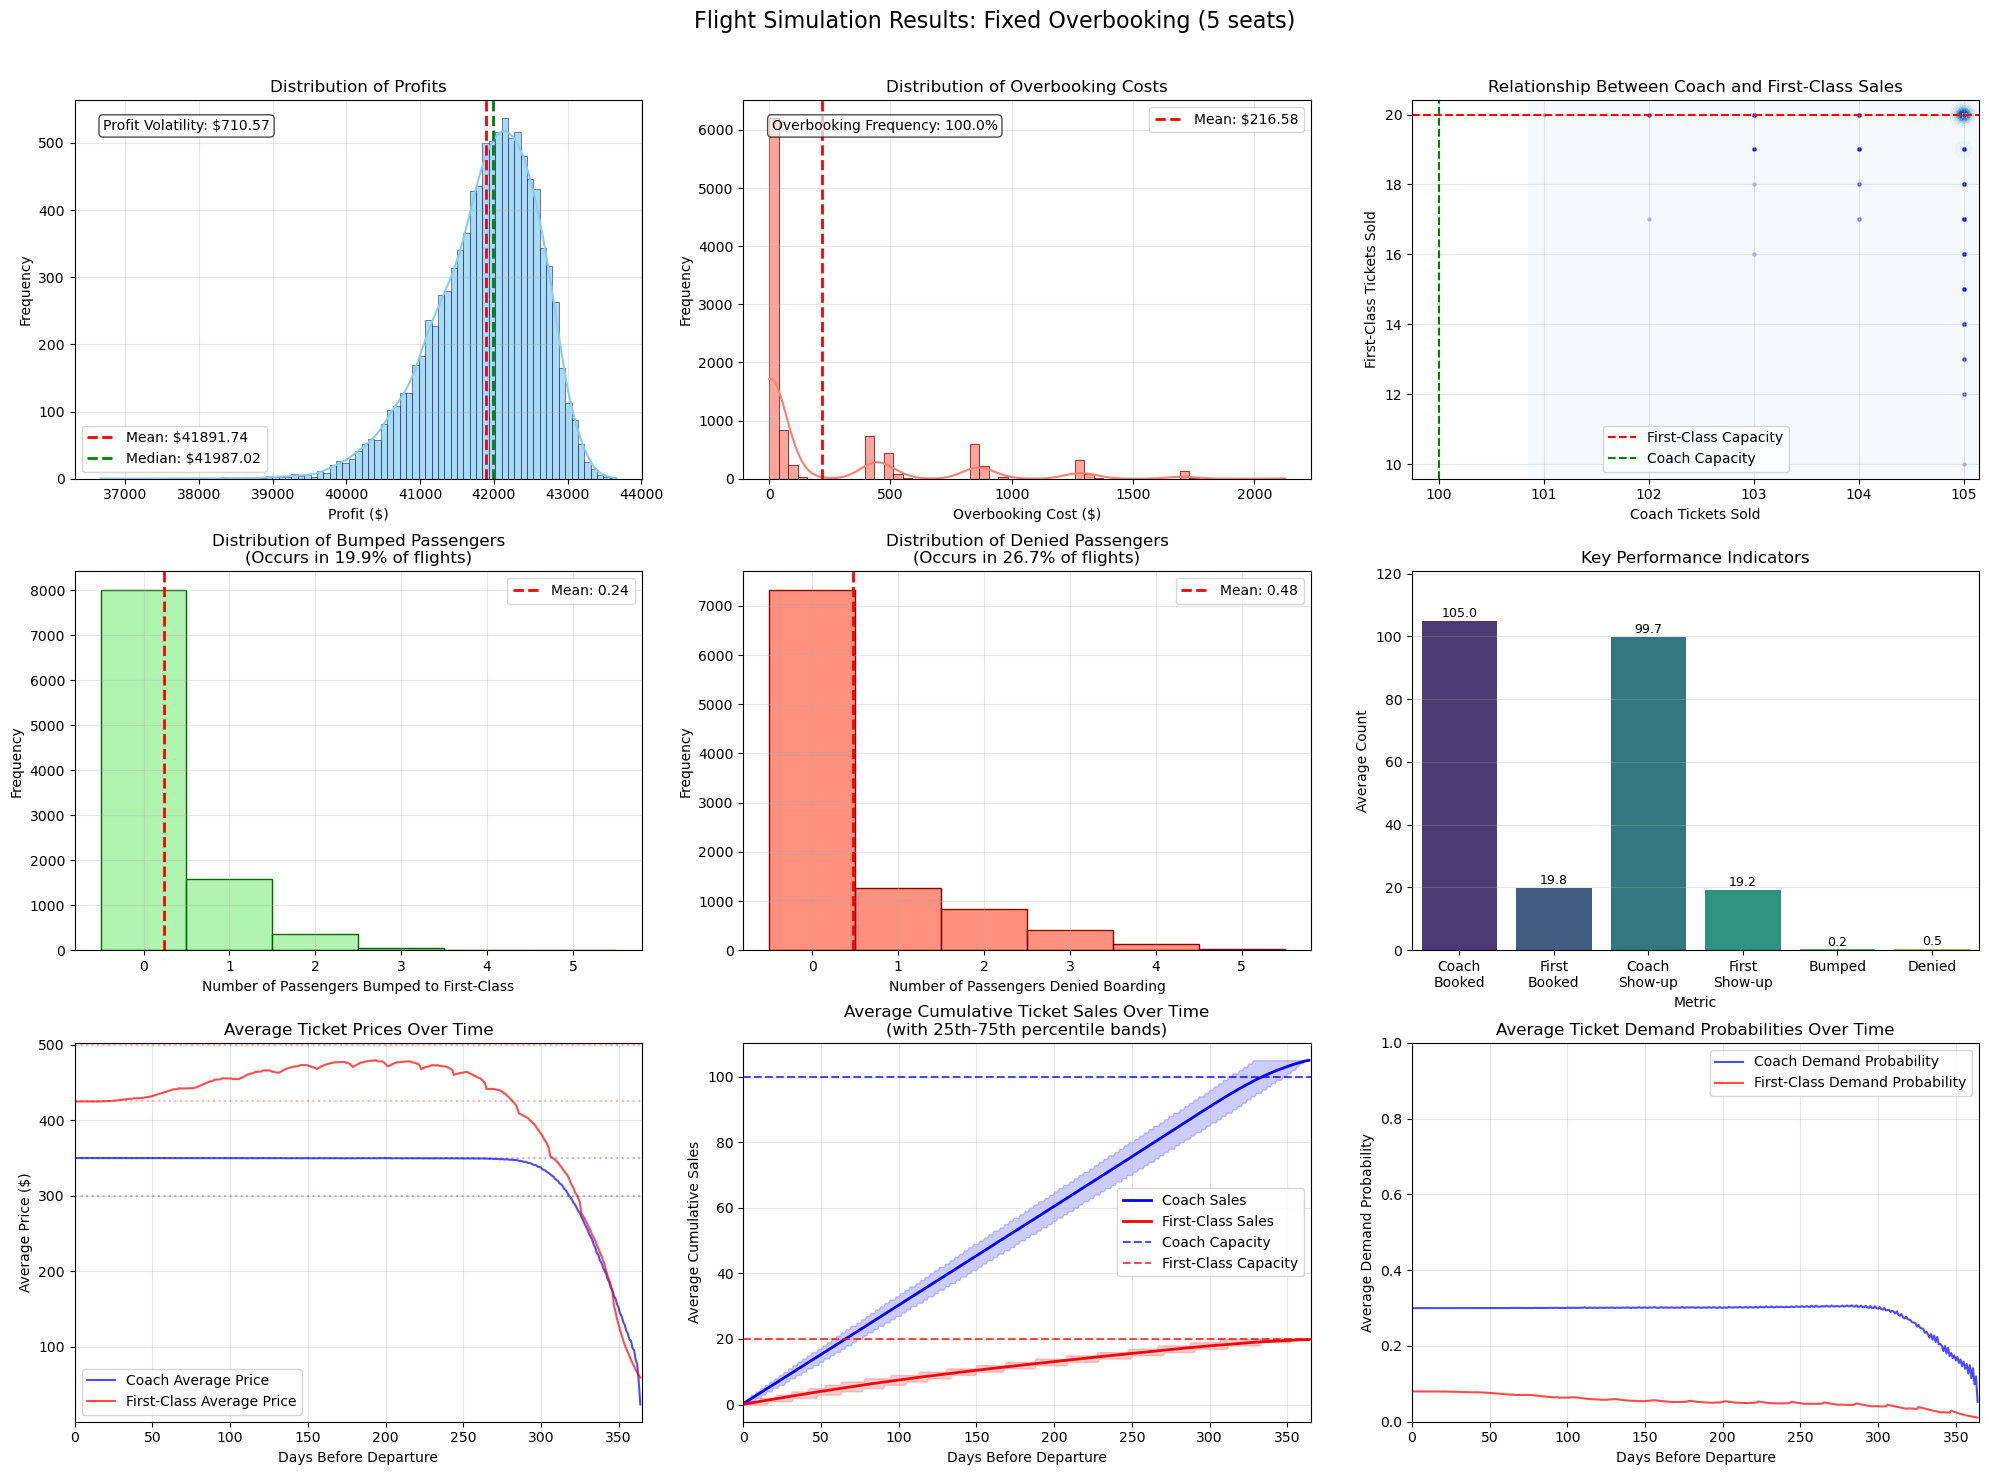

In [3]:
# Scenario 1
profit1, V1, U1 = calculate_expected_profit(overbooking_level=5)
print(f"Expected discounted profit with {5} oversold seats: ${profit1:.2f}")
print('\n')

results1 = simulate_flights(nsim=10000, U=U1, allow_no_coach_sale=False, seasonal_demand=False)

## Question 2

Expected discounted profit with 5 oversold seats: $41886.16
Expected discounted profit with 6 oversold seats: $42011.22
Expected discounted profit with 7 oversold seats: $42085.54
Expected discounted profit with 8 oversold seats: $42122.17
Expected discounted profit with 9 oversold seats: $42134.62
Expected discounted profit with 10 oversold seats: $42132.90
Expected discounted profit with 11 oversold seats: $42123.67
Expected discounted profit with 12 oversold seats: $42111.03
Expected discounted profit with 13 oversold seats: $42097.42
Expected discounted profit with 14 oversold seats: $42084.11
Expected discounted profit with 15 oversold seats: $42071.74

Optimal overbooking policy: 9 seats
Maximum expected profit: $42134.62


,Overbooking Level,Expected Profit
0,5,41886.158624
1,6,42011.221060
2,7,42085.536156
3,8,42122.167269
4,9,42134.624830
5,10,42132.900382
6,11,42123.665936
7,12,42111.029670
8,13,42097.419510
9,14,42084.111570


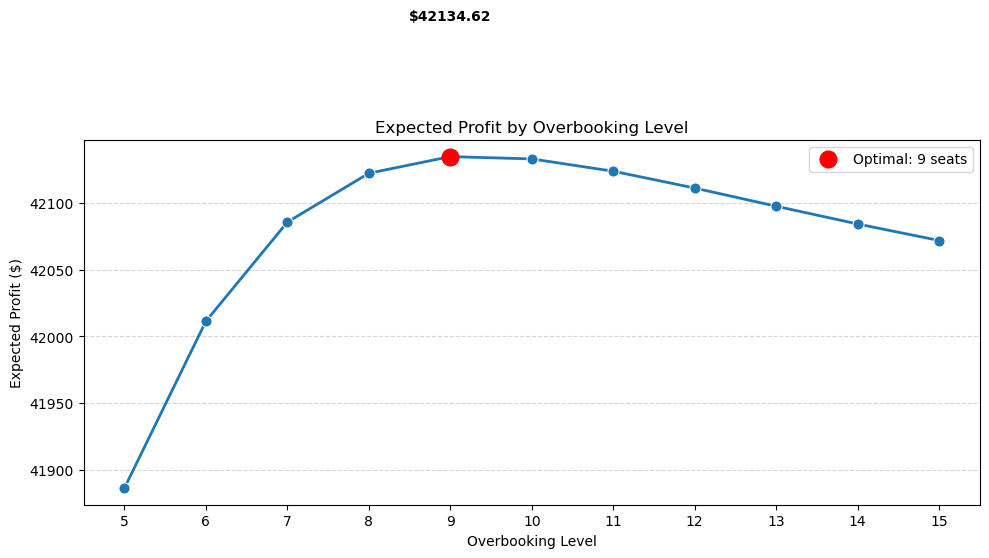

Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 49.57%
Frequency of denials: 69.92%
Average passengers bumped to first-class: 0.76
Average passengers denied boarding: 2.23
Average overbooking cost: $986.70
Average profit: $42120.06
Profit volatility (std dev): $930.85
Average coach tickets sold: 108.16
Average first-class tickets sold: 19.61


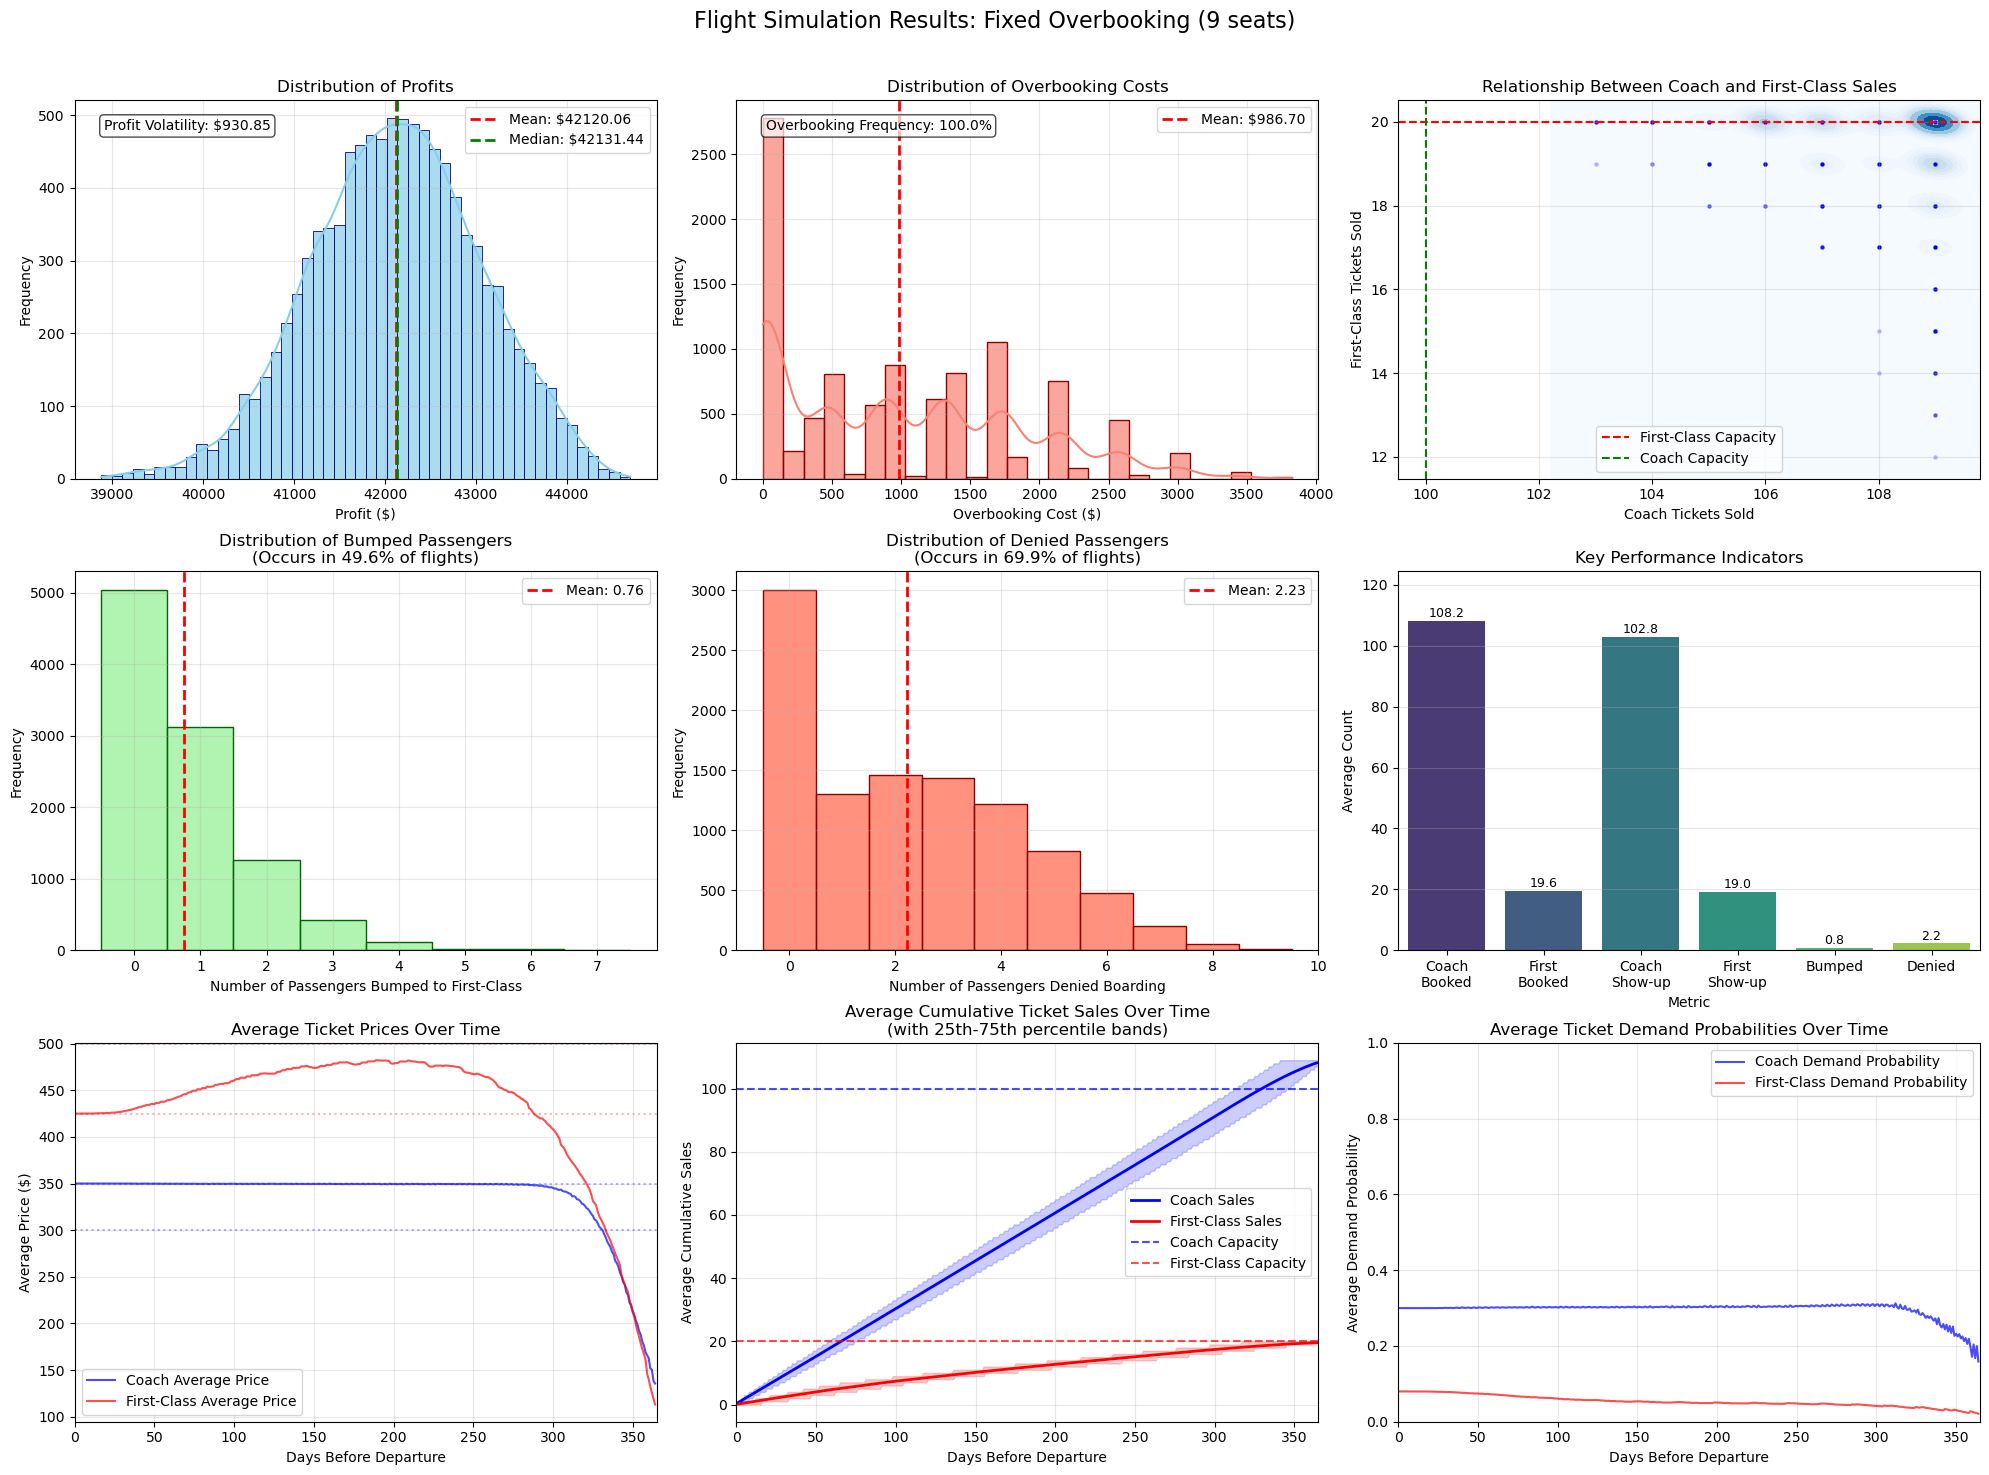

In [5]:
# Scenario 2
# Calculate results for each overbooking level
overbooking_results = {}
for overbooking in range(5, 16):  # 5 to 15 inclusive
    profit, V, U = calculate_expected_profit(overbooking_level=overbooking)
    overbooking_results[overbooking] = profit
    print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# Find the optimal overbooking policy
optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
print(f"\nOptimal overbooking policy: {optimal_overbooking} seats")
print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# Convert the results to a DataFrame for easier plotting
overbooking_df = pd.DataFrame({
    'Overbooking Level': list(overbooking_results.keys()),
    'Expected Profit': list(overbooking_results.values())
})

display(overbooking_df)

# Create the figure
plt.figure(figsize=(10, 6))

# Create a line plot with markers
sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
             marker='o', linewidth=2, markersize=8)

# Highlight the optimal point
optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
         'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# Add text label for the optimal value
plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
         f'${overbooking_results[optimal_overbooking]:.2f}',
         ha='center', va='bottom', fontweight='bold')

# Add labels and title
plt.xlabel('Overbooking Level')
plt.ylabel('Expected Profit ($)')
plt.title('Expected Profit by Overbooking Level')
plt.xticks(range(5, 16))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Save the best results
profit2, V2, U2 = calculate_expected_profit(overbooking_level=optimal_overbooking)

# Simulate outcome for best policy
results2 = simulate_flights(nsim=10000, U=U2, allow_no_coach_sale=False, seasonal_demand=False)

## Question 3

Expected discounted profit with 5 oversold seats: $41886.16
Expected discounted profit with 6 oversold seats: $42011.22
Expected discounted profit with 7 oversold seats: $42085.54
Expected discounted profit with 8 oversold seats: $42122.17
Expected discounted profit with 9 oversold seats: $42134.62
Expected discounted profit with 10 oversold seats: $42138.14
Expected discounted profit with 11 oversold seats: $42139.33
Expected discounted profit with 12 oversold seats: $42139.71
Expected discounted profit with 13 oversold seats: $42139.83
Expected discounted profit with 14 oversold seats: $42139.87
Expected discounted profit with 15 oversold seats: $42139.89
Expected discounted profit with 16 oversold seats: $42139.89
Expected discounted profit with 17 oversold seats: $42139.89
Expected discounted profit with 18 oversold seats: $42139.89
Expected discounted profit with 19 oversold seats: $42139.89
Expected discounted profit with 20 oversold seats: $42139.89

Optimal overbooking policy: 

,Overbooking Level,Expected Profit
0,5,41886.158624
1,6,42011.221060
2,7,42085.536156
3,8,42122.167269
4,9,42134.624830
5,10,42138.140498
6,11,42139.327940
7,12,42139.708945
8,13,42139.831425
9,14,42139.872225


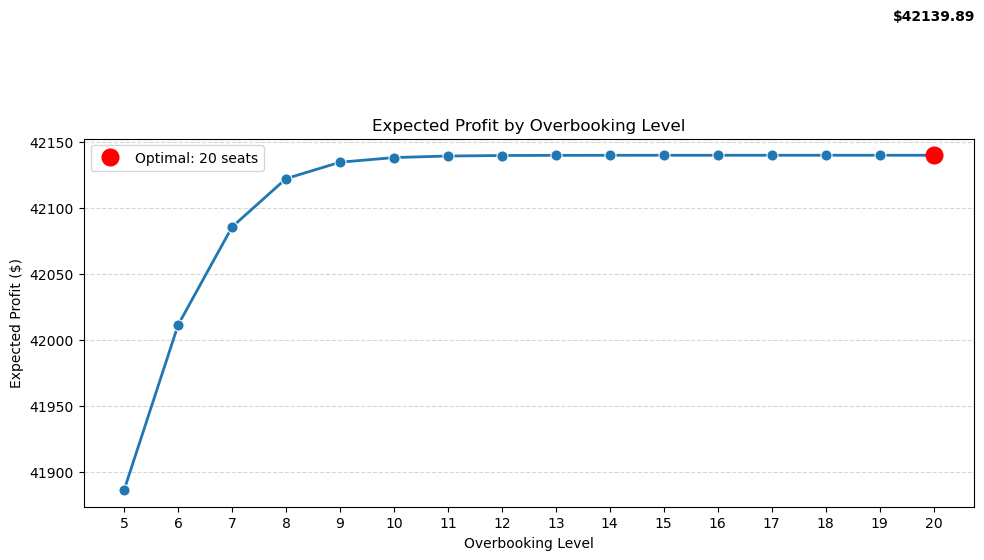

In [ ]:
# Scenario 3 (allow no coach sale)
# Calculate results for each overbooking level (not running because it takes a while)
# overbooking_results = {}
# for overbooking in range(5, 21):  # 5 to 20 inclusive
#     profit, V, U = calculate_expected_profit(overbooking_level=overbooking, allow_no_coach_sale=True, seasonal_demand=False)
#     overbooking_results[overbooking] = profit
#     print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# # Find the optimal overbooking policy
# optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
# print(f"\nOptimal overbooking policy: {optimal_overbooking} seats")
# print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# # Convert the results to a DataFrame for easier plotting
# overbooking_df = pd.DataFrame({
#     'Overbooking Level': list(overbooking_results.keys()),
#     'Expected Profit': list(overbooking_results.values())
# })

# display(overbooking_df)

# # Create the figure
# plt.figure(figsize=(10, 6))

# # Create a line plot with markers
# sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
#              marker='o', linewidth=2, markersize=8)

# # Highlight the optimal point
# optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
# plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
#          'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# # Add text label for the optimal value
# plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
#          f'${overbooking_results[optimal_overbooking]:.2f}',
#          ha='center', va='bottom', fontweight='bold')

# # Add labels and title
# plt.xlabel('Overbooking Level')
# plt.ylabel('Expected Profit ($)')
# plt.title('Expected Profit by Overbooking Level')
# plt.xticks(range(5, 21))
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.legend()

# plt.tight_layout()
# plt.show()

Expected discounted profit with 20 oversold seats and option to not sell coach ticket: $42139.89
Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 50.85%
Frequency of denials: 71.22%
Average passengers bumped to first-class: 0.82
Average passengers denied boarding: 2.33
Average overbooking cost: $1031.94
Average profit: $42156.82
Profit volatility (std dev): $942.89
Average coach tickets sold: 108.39
Average first-class tickets sold: 19.57


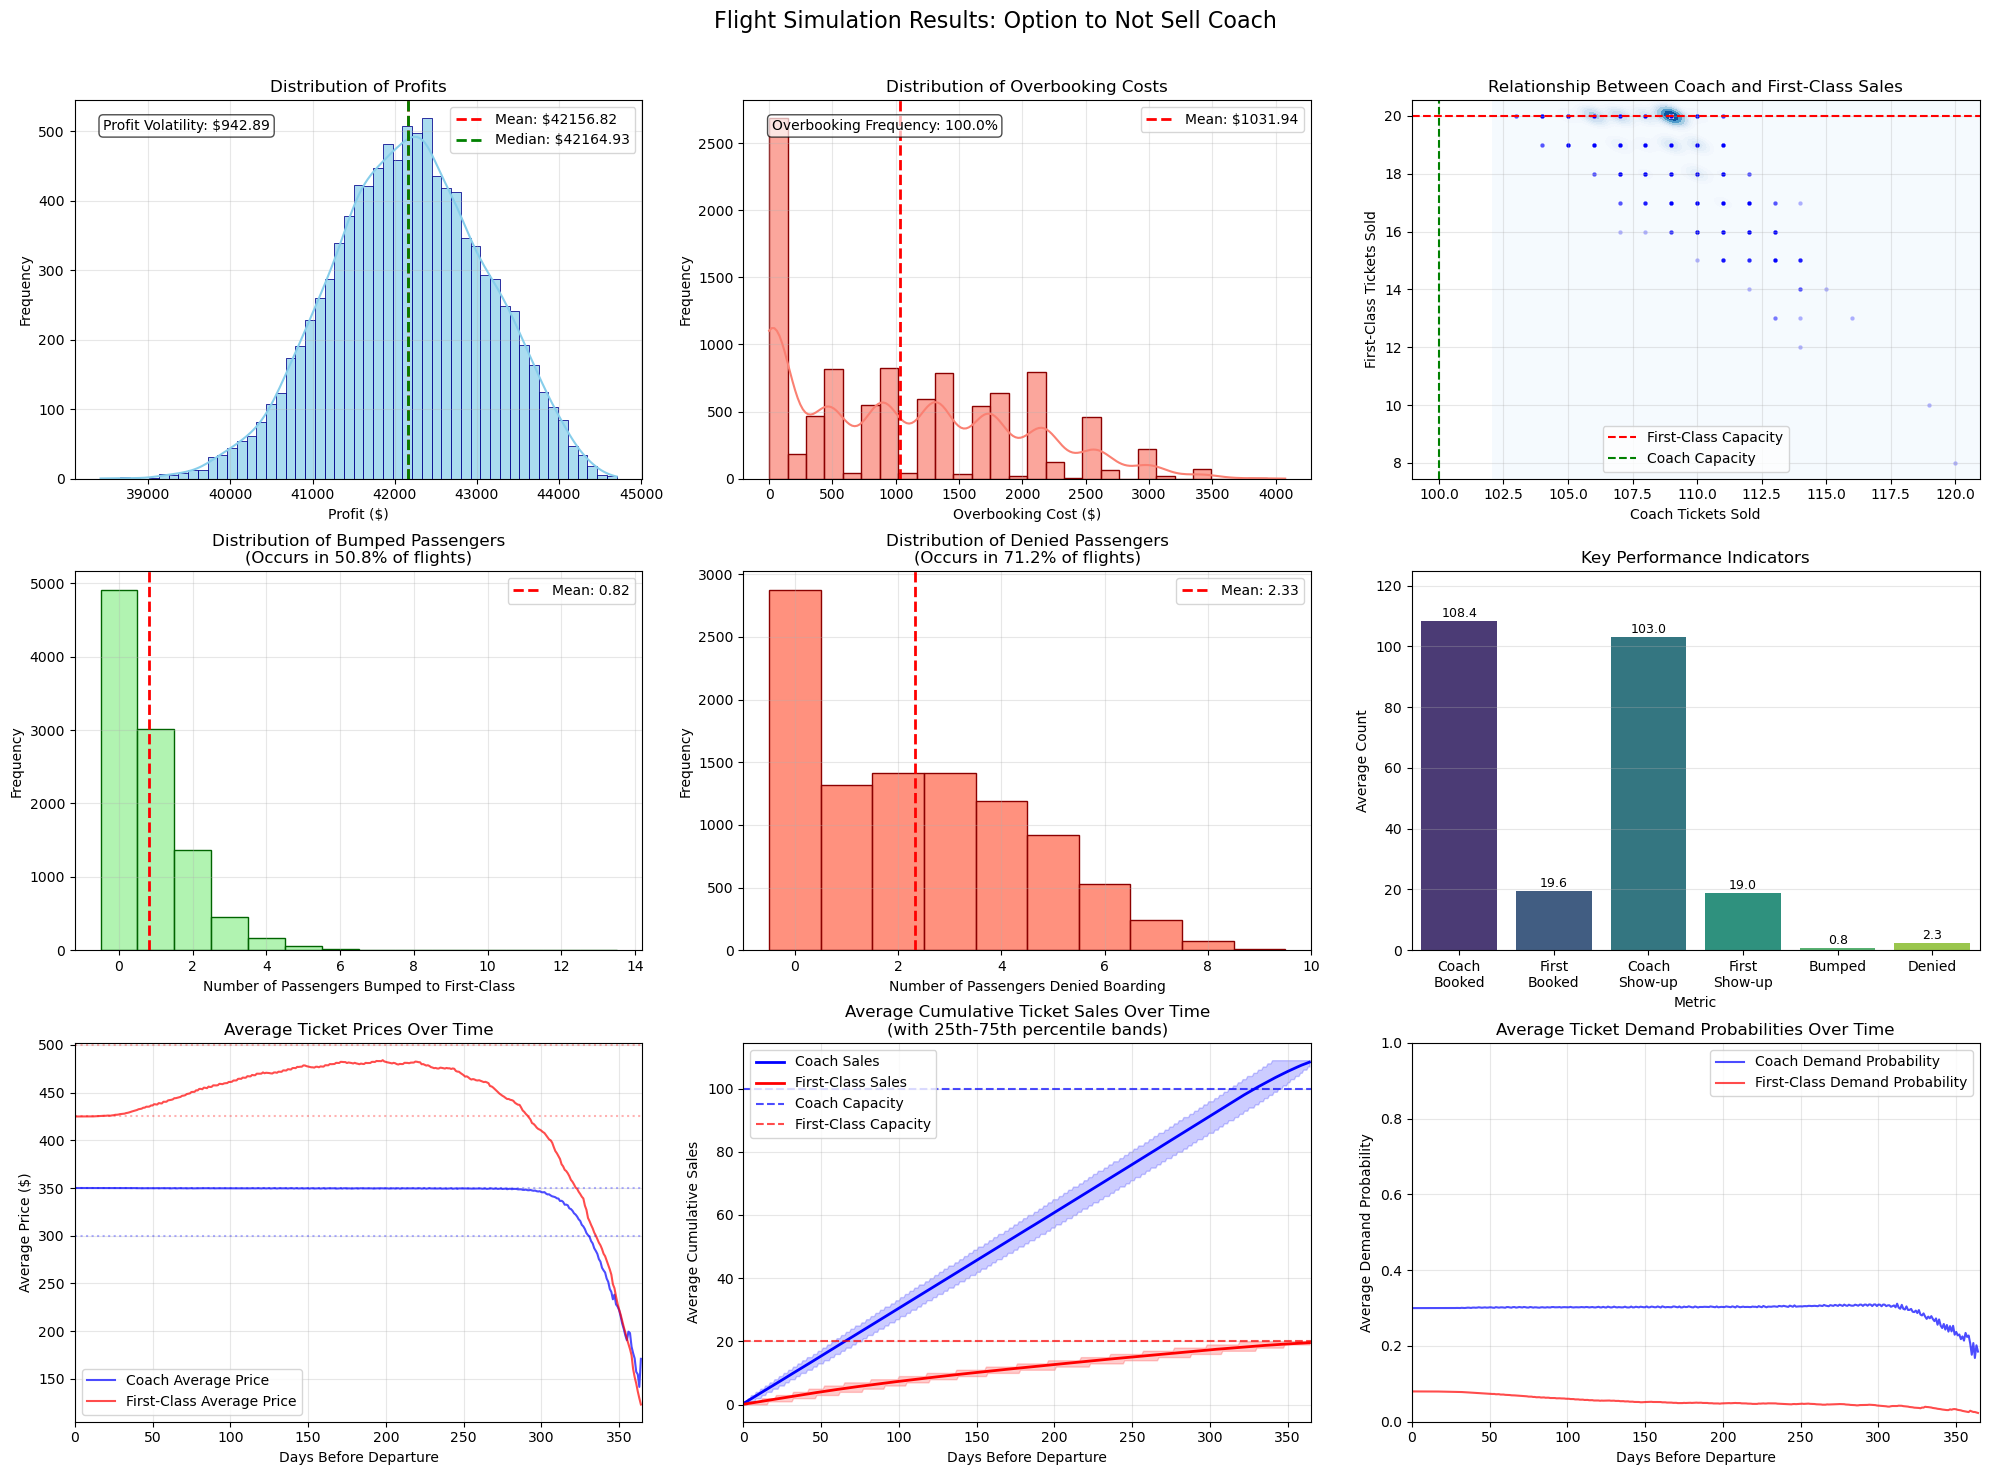

In [ ]:
# Save the best results
profit3, V3, U3 = calculate_expected_profit(overbooking_level=20, allow_no_coach_sale=True, seasonal_demand=False)
print(f"Expected discounted profit with {20} oversold seats and option to not sell coach ticket: ${profit3:.2f}")

# Simulate outcome for best policy
results3 = simulate_flights(nsim=10000, U=U3, allow_no_coach_sale=True, seasonal_demand=False)

## Question 4

Expected discounted profit with 5 oversold seats: $41580.54
Expected discounted profit with 6 oversold seats: $41704.54
Expected discounted profit with 7 oversold seats: $41777.15
Expected discounted profit with 8 oversold seats: $41812.89
Expected discounted profit with 9 oversold seats: $41825.07
Expected discounted profit with 10 oversold seats: $41828.65
Expected discounted profit with 11 oversold seats: $41829.88
Expected discounted profit with 12 oversold seats: $41830.27
Expected discounted profit with 13 oversold seats: $41830.40
Expected discounted profit with 14 oversold seats: $41830.44
Expected discounted profit with 15 oversold seats: $41830.45
Expected discounted profit with 16 oversold seats: $41830.45
Expected discounted profit with 17 oversold seats: $41830.46
Expected discounted profit with 18 oversold seats: $41830.46
Expected discounted profit with 19 oversold seats: $41830.46
Expected discounted profit with 20 oversold seats: $41830.46

Optimal overbooking policy: 

,Overbooking Level,Expected Profit
0,5,41580.540032
1,6,41704.540187
2,7,41777.149773
3,8,41812.891383
4,9,41825.072847
5,10,41828.650482
6,11,41829.876781
7,12,41830.271309
8,13,41830.396114
9,14,41830.436581


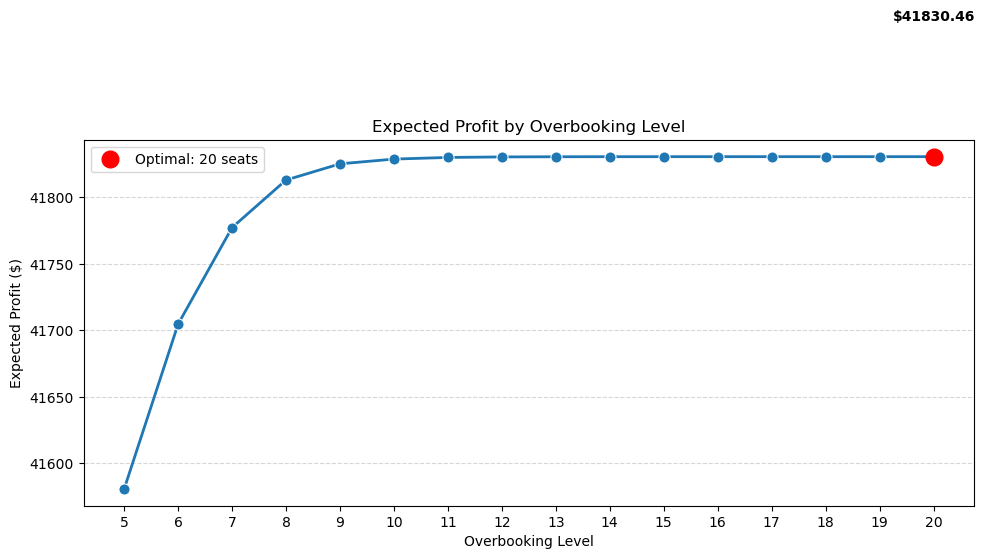

In [ ]:
# Scenario 4 (allow no coach sale and seasonal demand)
# Calculate results for each overbooking level (not running because it takes a while)
# overbooking_results = {}
# for overbooking in range(5, 21):  # 5 to 20 inclusive
#     profit, V, U = calculate_expected_profit(overbooking_level=overbooking, allow_no_coach_sale=True, seasonal_demand=True)
#     overbooking_results[overbooking] = profit
#     print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# # Find the optimal overbooking policy
# optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
# print(f"\nOptimal overbooking policy: {optimal_overbooking} seats")
# print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# # Convert the results to a DataFrame for easier plotting
# overbooking_df = pd.DataFrame({
#     'Overbooking Level': list(overbooking_results.keys()),
#     'Expected Profit': list(overbooking_results.values())
# })

# display(overbooking_df)

# # Create the figure
# plt.figure(figsize=(10, 6))

# # Create a line plot with markers
# sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
#              marker='o', linewidth=2, markersize=8)

# # Highlight the optimal point
# optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
# plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
#          'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# # Add text label for the optimal value
# plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
#          f'${overbooking_results[optimal_overbooking]:.2f}',
#          ha='center', va='bottom', fontweight='bold')

# # Add labels and title
# plt.xlabel('Overbooking Level')
# plt.ylabel('Expected Profit ($)')
# plt.title('Expected Profit by Overbooking Level')
# plt.xticks(range(5, 21))
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.legend()

# plt.tight_layout()
# plt.show()

Expected discounted profit with 20 oversold seats, option to not sell coach ticket, and demand seasonality: $41830.46
Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 51.38%
Frequency of denials: 71.40%
Average passengers bumped to first-class: 0.83
Average passengers denied boarding: 2.28
Average overbooking cost: $1010.51
Average profit: $41843.82
Profit volatility (std dev): $940.95
Average coach tickets sold: 108.36
Average first-class tickets sold: 19.56


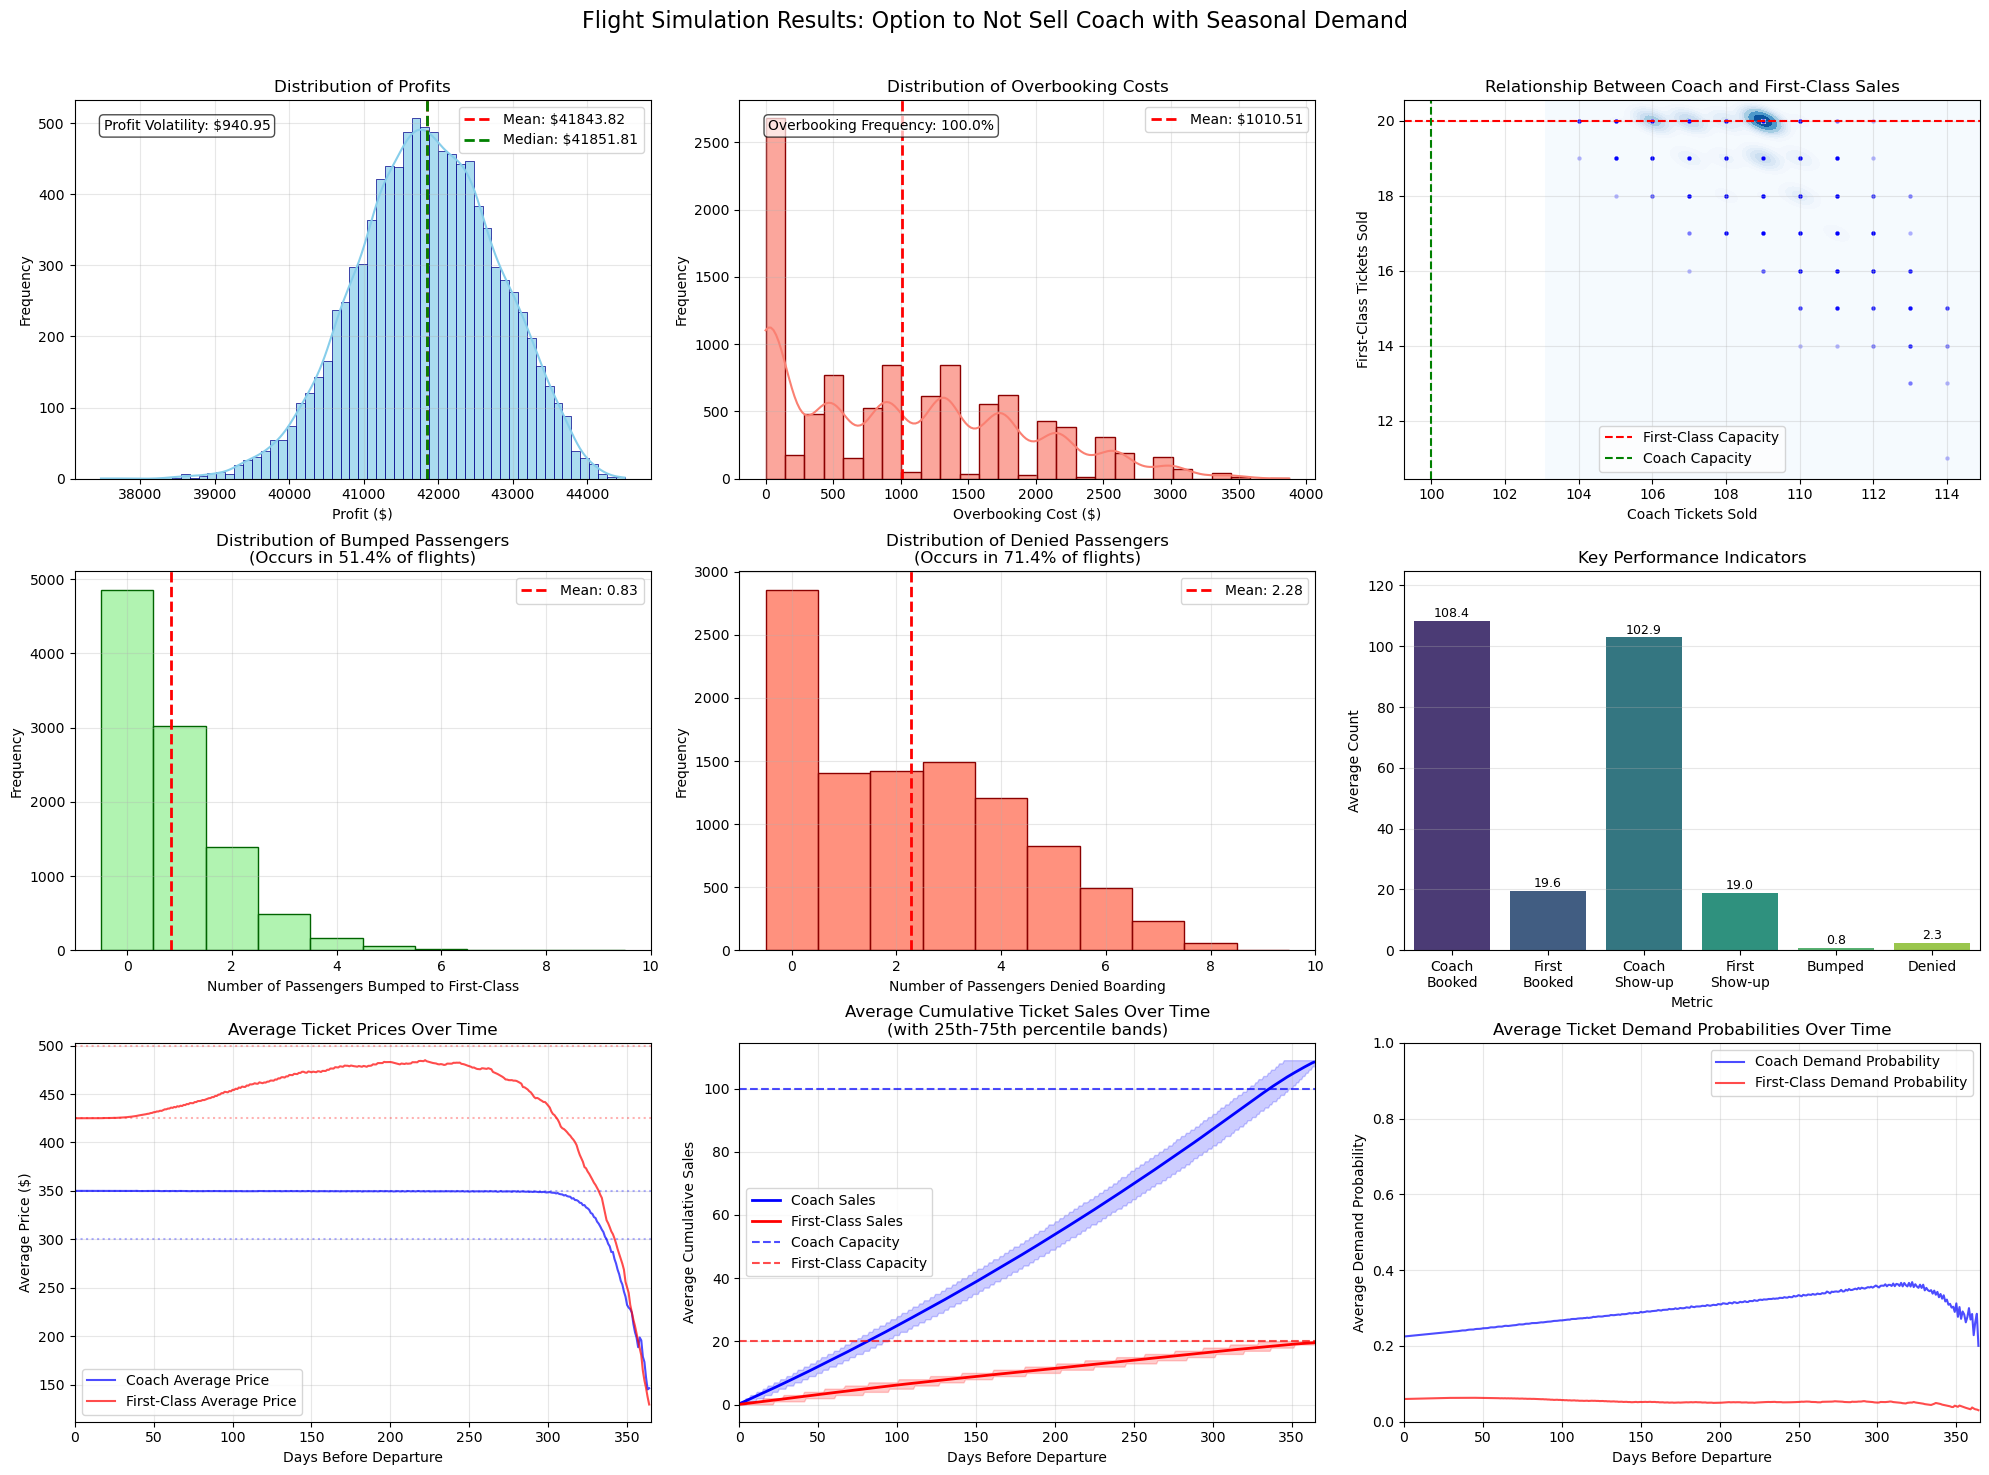

In [ ]:
# Scenario 4 (with seasonal demand)
profit4, V4, U4 = calculate_expected_profit(overbooking_level=20,allow_no_coach_sale=True,seasonal_demand=True)
print(f"Expected discounted profit with {20} oversold seats, option to not sell coach ticket, and demand seasonality: ${profit4:.2f}")

results4 = simulate_flights(nsim=10000, U=U4, allow_no_coach_sale=True, seasonal_demand=True)

## Question 5
Refer to the figures above for simulations for each scenario.

The figure below summarizes the results across all scenarios.

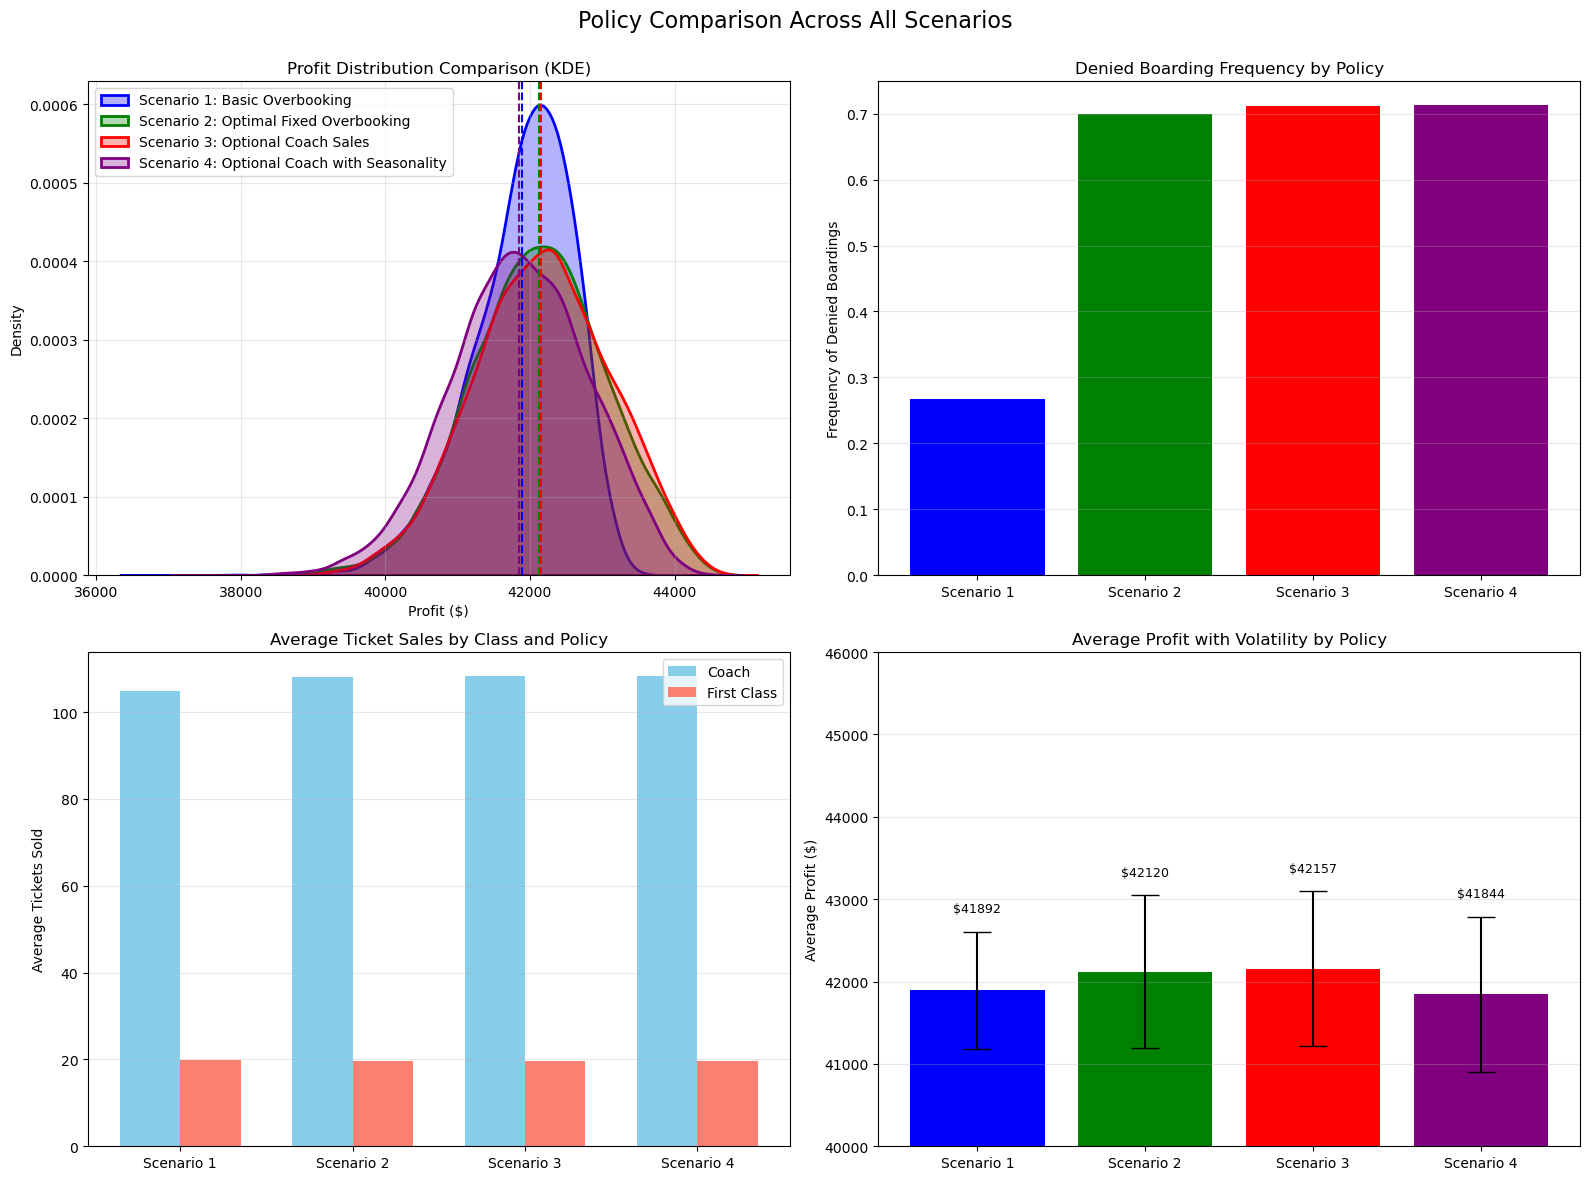


Policy Comparison Summary:
--------------------------------------------------------------------------------
Metric               Scenario 1      Scenario 2      Scenario 3      Scenario 4     
--------------------------------------------------------------------------------
Avg. Profit          $41891.74       $42120.06       $42156.82       $41843.82      
Profit Std Dev       $710.57         $930.85         $942.89         $940.95        
Denied Freq.         26.68%         69.92%         71.22%         71.40%        
Avg. Coach Sales     104.96         108.16         108.39         108.36        
Avg. First Sales     19.80          19.61          19.57          19.56         
--------------------------------------------------------------------------------
Profit improvement over baseline: 0.55%, 0.63%, -0.11%


In [10]:
def compare_policies(results1, results2, results3, results4):
    """
    Compare the results of the four different policies
    """
    # Create a figure for comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Compare profit distributions using KDE plot instead of histogram
    sns.kdeplot(results1['profit_array'], ax=axes[0, 0], color='blue', fill=True, alpha=0.3, 
               label='Scenario 1: Basic Overbooking', linewidth=2)
    sns.kdeplot(results2['profit_array'], ax=axes[0, 0], color='green', fill=True, alpha=0.3, 
               label='Scenario 2: Optimal Fixed Overbooking', linewidth=2)
    sns.kdeplot(results3['profit_array'], ax=axes[0, 0], color='red', fill=True, alpha=0.3, 
               label='Scenario 3: Optional Coach Sales', linewidth=2)
    sns.kdeplot(results4['profit_array'], ax=axes[0, 0], color='purple', fill=True, alpha=0.3, 
               label='Scenario 4: Optional Coach with Seasonality', linewidth=2)
    
    # Add vertical lines for mean values
    mean1 = np.mean(results1['profit_array'])
    mean2 = np.mean(results2['profit_array'])
    mean3 = np.mean(results3['profit_array'])
    mean4 = np.mean(results4['profit_array'])
    
    axes[0, 0].axvline(mean1, color='blue', linestyle='--', linewidth=1.5)
    axes[0, 0].axvline(mean2, color='green', linestyle='--', linewidth=1.5)
    axes[0, 0].axvline(mean3, color='red', linestyle='--', linewidth=1.5)
    axes[0, 0].axvline(mean4, color='purple', linestyle='--', linewidth=1.5)
    
    axes[0, 0].set_xlabel('Profit ($)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Profit Distribution Comparison (KDE)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Compare denied boarding frequencies
    denied_freq = [
        np.sum(results1['denied_array'] > 0) / len(results1['denied_array']),
        np.sum(results2['denied_array'] > 0) / len(results2['denied_array']),
        np.sum(results3['denied_array'] > 0) / len(results3['denied_array']),
        np.sum(results4['denied_array'] > 0) / len(results4['denied_array'])
    ]
    axes[0, 1].bar(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'], 
                  denied_freq, color=['blue', 'green', 'red', 'purple'])
    axes[0, 1].set_ylabel('Frequency of Denied Boardings')
    axes[0, 1].set_title('Denied Boarding Frequency by Policy')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Compare average ticket sales
    avg_coach = [
        np.mean(results1['coach_sold_array']),
        np.mean(results2['coach_sold_array']),
        np.mean(results3['coach_sold_array']),
        np.mean(results4['coach_sold_array'])
    ]
    avg_first = [
        np.mean(results1['first_sold_array']),
        np.mean(results2['first_sold_array']),
        np.mean(results3['first_sold_array']),
        np.mean(results4['first_sold_array'])
    ]
    
    x = np.arange(4)
    width = 0.35
    axes[1, 0].bar(x - width/2, avg_coach, width, label='Coach', color='skyblue')
    axes[1, 0].bar(x + width/2, avg_first, width, label='First Class', color='salmon')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'])
    axes[1, 0].set_ylabel('Average Tickets Sold')
    axes[1, 0].set_title('Average Ticket Sales by Class and Policy')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Compare profit statistics
    avg_profits = [
        np.mean(results1['profit_array']),
        np.mean(results2['profit_array']),
        np.mean(results3['profit_array']),
        np.mean(results4['profit_array'])
    ]
    std_profits = [
        np.std(results1['profit_array']),
        np.std(results2['profit_array']),
        np.std(results3['profit_array']),
        np.std(results4['profit_array'])
    ]
    
    profit_bars = axes[1, 1].bar(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'], 
                  avg_profits, yerr=std_profits, capsize=10, 
                  color=['blue', 'green', 'red', 'purple'])
    
    # Add profit values above bars
    for i, bar in enumerate(profit_bars):
        profit_value = avg_profits[i]
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_profits[i] + 200,
                       f'${profit_value:.0f}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 1].set_ylim(40000, 46000)  # Adjusted to make room for text
    axes[1, 1].set_ylabel('Average Profit ($)')
    axes[1, 1].set_title('Average Profit with Volatility by Policy')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Policy Comparison Across All Scenarios', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Print summary table of key metrics
    print("\nPolicy Comparison Summary:")
    print("-" * 80)
    print(f"{'Metric':<20} {'Scenario 1':<15} {'Scenario 2':<15} {'Scenario 3':<15} {'Scenario 4':<15}")
    print("-" * 80)
    print(f"{'Avg. Profit':<20} ${avg_profits[0]:<14.2f} ${avg_profits[1]:<14.2f} ${avg_profits[2]:<14.2f} ${avg_profits[3]:<14.2f}")
    print(f"{'Profit Std Dev':<20} ${std_profits[0]:<14.2f} ${std_profits[1]:<14.2f} ${std_profits[2]:<14.2f} ${std_profits[3]:<14.2f}")
    print(f"{'Denied Freq.':<20} {denied_freq[0]:<14.2%} {denied_freq[1]:<14.2%} {denied_freq[2]:<14.2%} {denied_freq[3]:<14.2%}")
    print(f"{'Avg. Coach Sales':<20} {avg_coach[0]:<14.2f} {avg_coach[1]:<14.2f} {avg_coach[2]:<14.2f} {avg_coach[3]:<14.2f}")
    print(f"{'Avg. First Sales':<20} {avg_first[0]:<14.2f} {avg_first[1]:<14.2f} {avg_first[2]:<14.2f} {avg_first[3]:<14.2f}")
    print("-" * 80)

    # Return profit improvement percentages for easy comparison
    baseline_profit = avg_profits[0]  # Scenario 1 as baseline
    improvements = [(profit - baseline_profit) / baseline_profit * 100 for profit in avg_profits]
    
    return {
        'avg_profits': avg_profits,
        'profit_improvements': improvements,
        'denied_freq': denied_freq
    }

comparison = compare_policies(results1, results2, results3, results4)
print(f"Profit improvement over baseline: {comparison['profit_improvements'][1]:.2f}%, {comparison['profit_improvements'][2]:.2f}%, {comparison['profit_improvements'][3]:.2f}%")

## Analyzing the best policy

In [ ]:
def visualize_u_matrix_over_time(U, coach_seats, first_class_seats, allow_no_coach_sale=True, days=365, time_steps=6):
    """
    Visualize how the optimal decision matrix (U) changes over time.
    
    Parameters:
    -----------
    U : numpy.ndarray
        The optimal decision matrix with shape (days, coach_cap, first_class_seats+1)
    coach_seats : int
        Number of coach seats
    first_class_seats : int
        Number of first-class seats
    allow_no_coach_sale : bool
        Whether the policy allows not selling coach tickets
    days : int
        Total number of days in the simulation
    time_steps : int
        Number of time snapshots to visualize
    """
    # Create a figure with subplots for different time points
    fig, axes = plt.subplots(2, time_steps//2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Define coach capacity (max number of coach tickets that can be sold)
    coach_cap = U.shape[1] - 1
    
    # Create a colormap for the decisions
    if allow_no_coach_sale:
        # Define a custom colormap for the 12 possible decisions (0-11)
        decision_labels = [
            "LL", "LH", "HL", "HH", 
            "NL", "NH", "L-", "H-", 
            "N-", "-L", "-H", "No Sale"
        ]
        cmap = plt.cm.get_cmap('viridis', 12)
    else:
        # Define a custom colormap for the 9 possible decisions (0-8)
        decision_labels = [
            "LL", "LH", "HL", "HH", 
            "L-", "H-", "-L", "-H", "No Sale"
        ]
        cmap = plt.cm.get_cmap('viridis', 9)
    
    # Select time points to visualize
    time_points = np.linspace(0, days-1, time_steps, dtype=int)
    
    # Create a heatmap for each selected time point
    for i, t in enumerate(time_points):
        ax = axes[i]
        
        # Extract the U matrix for the current time point
        U_t = U[t, :, :]
        
        # Create heatmap
        im = ax.imshow(U_t, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # Add gridlines
        ax.set_xticks(np.arange(-.5, first_class_seats + 1, 1), minor=True)
        ax.set_yticks(np.arange(-.5, coach_cap + 1, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
        
        # Set axis labels and title
        ax.set_title(f'Day {t} (T-{days-t})')
        ax.set_xlabel('First-Class Tickets Sold')
        ax.set_ylabel('Coach Tickets Sold')
        
        # Set tick positions and labels
        ax.set_xticks(np.arange(0, first_class_seats + 1, 5))
        ax.set_yticks(np.arange(0, coach_cap + 1, 5))
        
        # Add capacity lines
        ax.axhline(y=coach_seats - 0.5, color='red', linestyle='--', linewidth=2)
        ax.axvline(x=first_class_seats - 0.5, color='red', linestyle='--', linewidth=2)
    
    # Create a colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    
    # Add tick labels to the colorbar for each decision
    tick_locs = np.arange(len(decision_labels)) + 0.5
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(decision_labels)
    
    # Add main title and adjust layout
    plt.suptitle(f'Optimal Decision Matrix (U) Evolution Over Time', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    return fig, axes

def create_decision_explanation_table(allow_no_coach_sale=True):
    """
    Create a DataFrame explaining the decision codes in the U-matrix.
    """
    if allow_no_coach_sale:
        decisions = {
            "Code": range(12),
            "Label": ["LL", "LH", "HL", "HH", "NL", "NH", "L-", "H-", "N-", "-L", "-H", "No Sale"],
            "Coach Price": ["Low", "Low", "High", "High", "None", "None", "Low", "High", "None", "None", "None", "None"],
            "First Price": ["Low", "High", "Low", "High", "Low", "High", "None", "None", "None", "Low", "High", "None"],
            "Description": [
                "Offer both at low prices", 
                "Low coach, high first-class", 
                "High coach, low first-class",
                "Offer both at high prices",
                "Don't sell coach, low first-class",
                "Don't sell coach, high first-class",
                "Sell only coach at low price (first-class sold out)",
                "Sell only coach at high price (first-class sold out)",
                "Don't sell either (but first-class is sold out)",
                "Sell only first-class at low price (coach sold out)",
                "Sell only first-class at high price (coach sold out)",
                "Don't sell either ticket type"
            ]
        }
    else:
        decisions = {
            "Code": range(9),
            "Label": ["LL", "LH", "HL", "HH", "L-", "H-", "-L", "-H", "No Sale"],
            "Coach Price": ["Low", "Low", "High", "High", "Low", "High", "None", "None", "None"],
            "First Price": ["Low", "High", "Low", "High", "None", "None", "Low", "High", "None"],
            "Description": [
                "Offer both at low prices", 
                "Low coach, high first-class", 
                "High coach, low first-class",
                "Offer both at high prices",
                "Sell only coach at low price (first-class sold out)",
                "Sell only coach at high price (first-class sold out)",
                "Sell only first-class at low price (coach sold out)",
                "Sell only first-class at high price (coach sold out)",
                "Don't sell either ticket type"
            ]
        }
    
    return pd.DataFrame(decisions)

def visualize_decision_distribution(U, allow_no_coach_sale=True):
    """
    Visualize how the distribution of decisions changes over time.
    """
    days = U.shape[0]
    decision_counts = []
    
    # Count the frequency of each decision for each day
    for day in range(days):
        unique, counts = np.unique(U[day], return_counts=True)
        decision_count = dict(zip(unique, counts))
        
        # Ensure all decision types are represented
        max_decision = 11 if allow_no_coach_sale else 8
        for i in range(max_decision + 1):
            if i not in decision_count:
                decision_count[i] = 0
                
        decision_counts.append(decision_count)
    
    # Convert to DataFrame for easier plotting
    df_counts = pd.DataFrame(decision_counts)
    
    # Get decision labels
    if allow_no_coach_sale:
        decision_labels = ["LL", "LH", "HL", "HH", "NL", "NH", "L-", "H-", "N-", "-L", "-H", "No Sale"]
        # Create a custom colormap with distinct colors for each decision
        colors = [
            '#1f77b4',  # blue - LL
            '#ff7f0e',  # orange - LH
            '#2ca02c',  # green - HL
            '#d62728',  # red - HH
            '#9467bd',  # purple - NL
            '#8c564b',  # brown - NH
            '#e377c2',  # pink - L-
            '#7f7f7f',  # gray - H-
            '#bcbd22',  # olive - N-
            '#17becf',  # cyan - -L
            '#aec7e8',  # light blue - -H
            '#ffbb78'   # light orange - No Sale
        ]
    else:
        decision_labels = ["LL", "LH", "HL", "HH", "L-", "H-", "-L", "-H", "No Sale"]
        # Create a custom colormap with distinct colors for each decision
        colors = [
            '#1f77b4',  # blue - LL
            '#ff7f0e',  # orange - LH
            '#2ca02c',  # green - HL
            '#d62728',  # red - HH
            '#e377c2',  # pink - L-
            '#7f7f7f',  # gray - H-
            '#17becf',  # cyan - -L
            '#aec7e8',  # light blue - -H
            '#ffbb78'   # light orange - No Sale
        ]
    
    # Fill missing columns with zeros
    for i, label in enumerate(decision_labels):
        if i not in df_counts.columns:
            df_counts[i] = 0
    
    # Sort columns
    df_counts = df_counts.sort_index(axis=1)
    
    # Create a stacked area chart
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Get x values (days from departure)
    x = np.arange(days)
    
    # Create stacked area chart
    bottom = np.zeros(days)
    for i, label in enumerate(decision_labels):
        if i in df_counts.columns:
            ax.fill_between(x, bottom, bottom + df_counts[i], 
                           label=label, alpha=0.8, color=colors[i])
            bottom += df_counts[i]
    
    # Add labels and legend
    ax.set_xlabel('Days Before Departure')
    ax.set_ylabel('Number of States')
    ax.set_title('Distribution of Optimal Decisions Over Time')
    
    # Create a more organized legend with multiple columns and a title
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=2, 
                      title="Decision Types", fontsize=10, title_fontsize=12)
    
    # Add a shadow effect to make legend stand out
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(0.5)
    
    # Invert x-axis to show time progression towards departure
    ax.invert_xaxis()
    
    # Add some key time markers (e.g., 1 year, 6 months, 3 months, 1 month before departure)
    for day_mark in [365, 180, 90, 30]:
        if day_mark < days:
            ax.axvline(x=day_mark, color='black', linestyle='--', alpha=0.3)
            ax.text(day_mark, ax.get_ylim()[1]*0.95, f"{day_mark} days", 
                   ha='center', va='top', backgroundcolor='white', alpha=0.7)
    
    # Show grid
    ax.grid(alpha=0.3)
    
    # Add annotations explaining key decision types
    # Position the annotations in the empty space
    explain_text = "Decision Key:\n"
    explain_text += "L = Low Price, H = High Price\n"
    explain_text += "N = No Sale, - = Not Available\n"
    explain_text += "First position = Coach, Second = First Class"
    
    # Add a text box with explanation
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.02, 0.98, explain_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    return fig, ax

/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_38793/569876158.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 12)
/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_38793/569876158.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


,Code,Label,Coach Price,First Price,Description
0,0,LL,Low,Low,Offer both at low prices
1,1,LH,Low,High,"Low coach, high first-class"
2,2,HL,High,Low,"High coach, low first-class"
3,3,HH,High,High,Offer both at high prices
4,4,NL,None,Low,"Don't sell coach, low first-class"
5,5,NH,None,High,"Don't sell coach, high first-class"
6,6,L-,Low,None,Sell only coach at low price (first-class sold...
7,7,H-,High,None,Sell only coach at high price (first-class sol...
8,8,N-,None,None,Don't sell either (but first-class is sold out)
9,9,-L,None,Low,Sell only first-class at low price (coach sold...


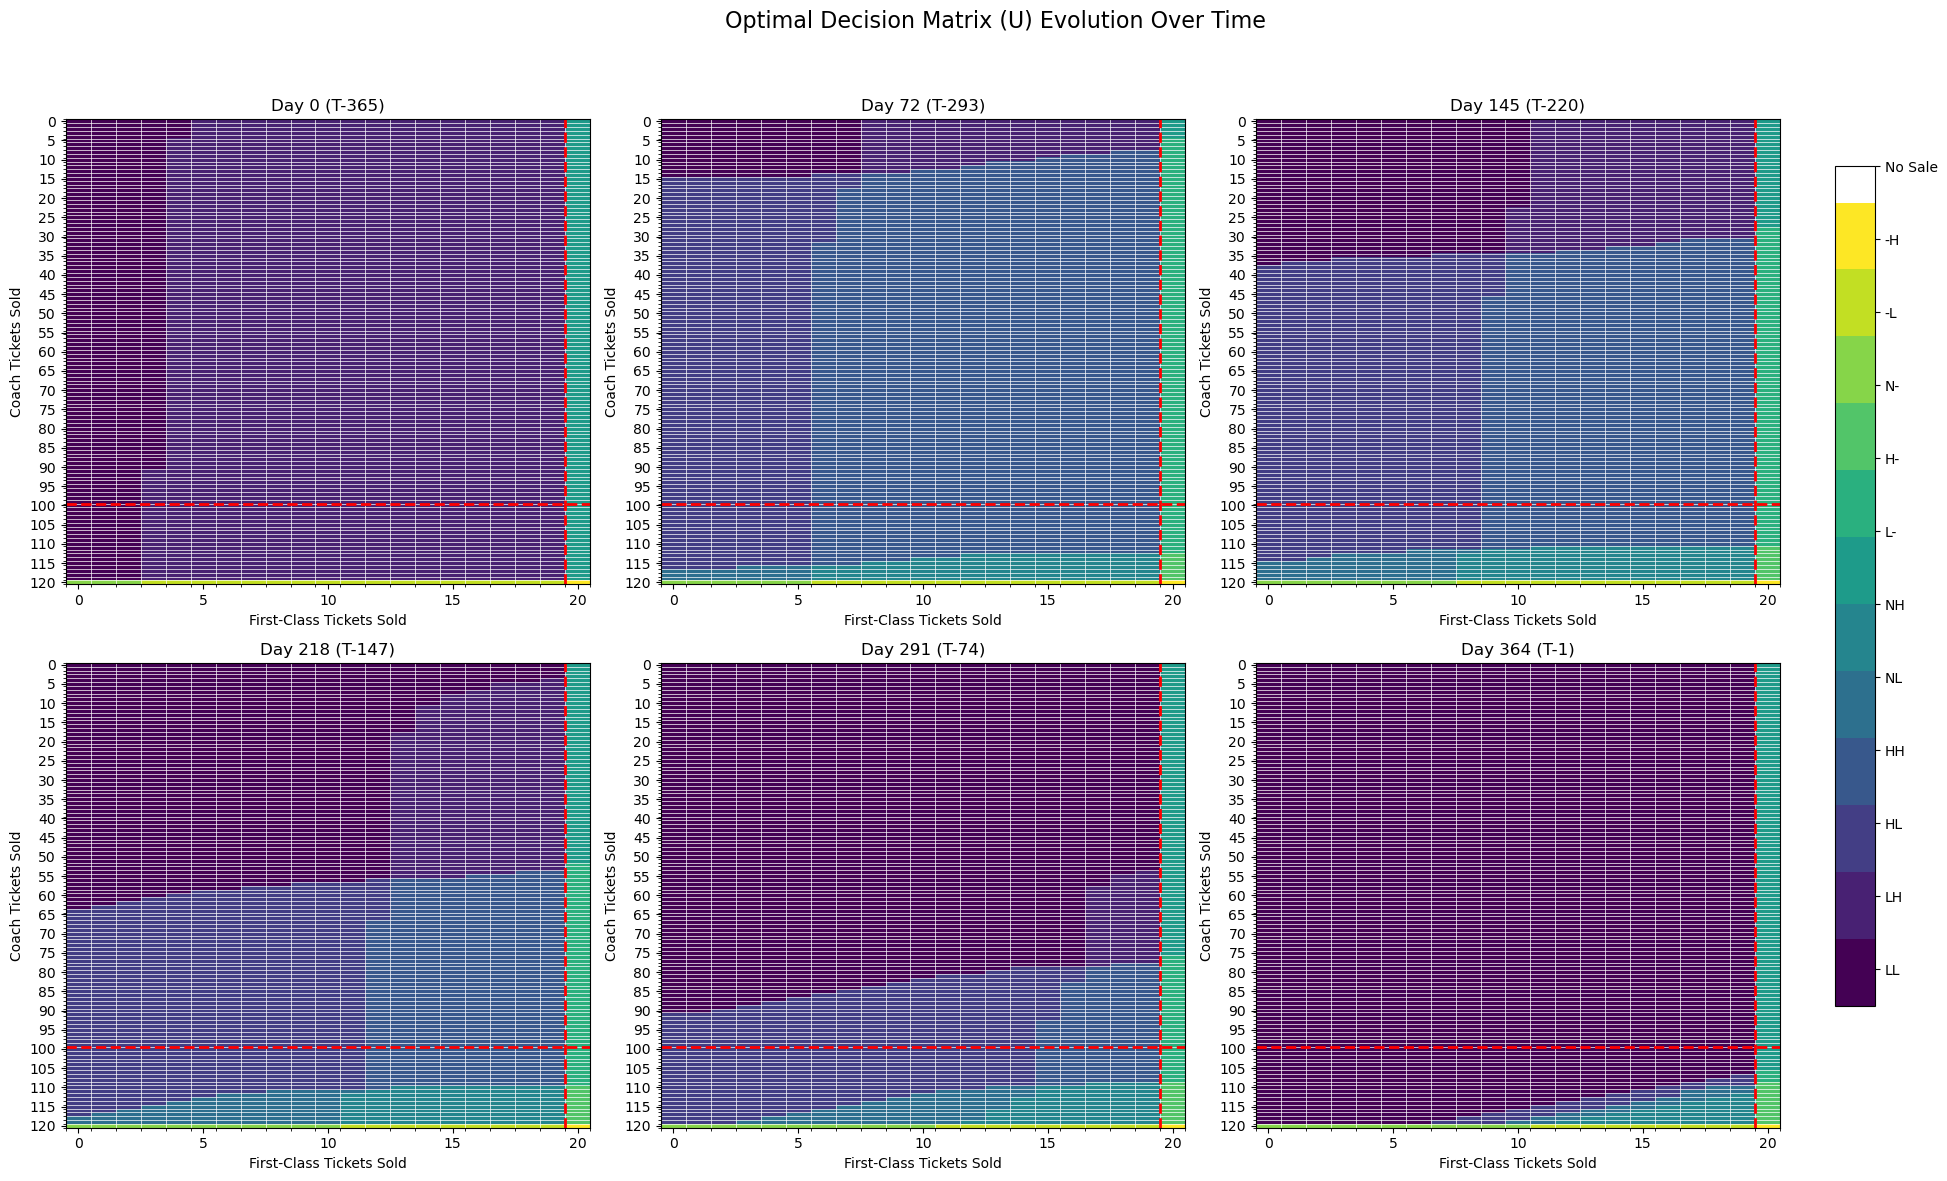

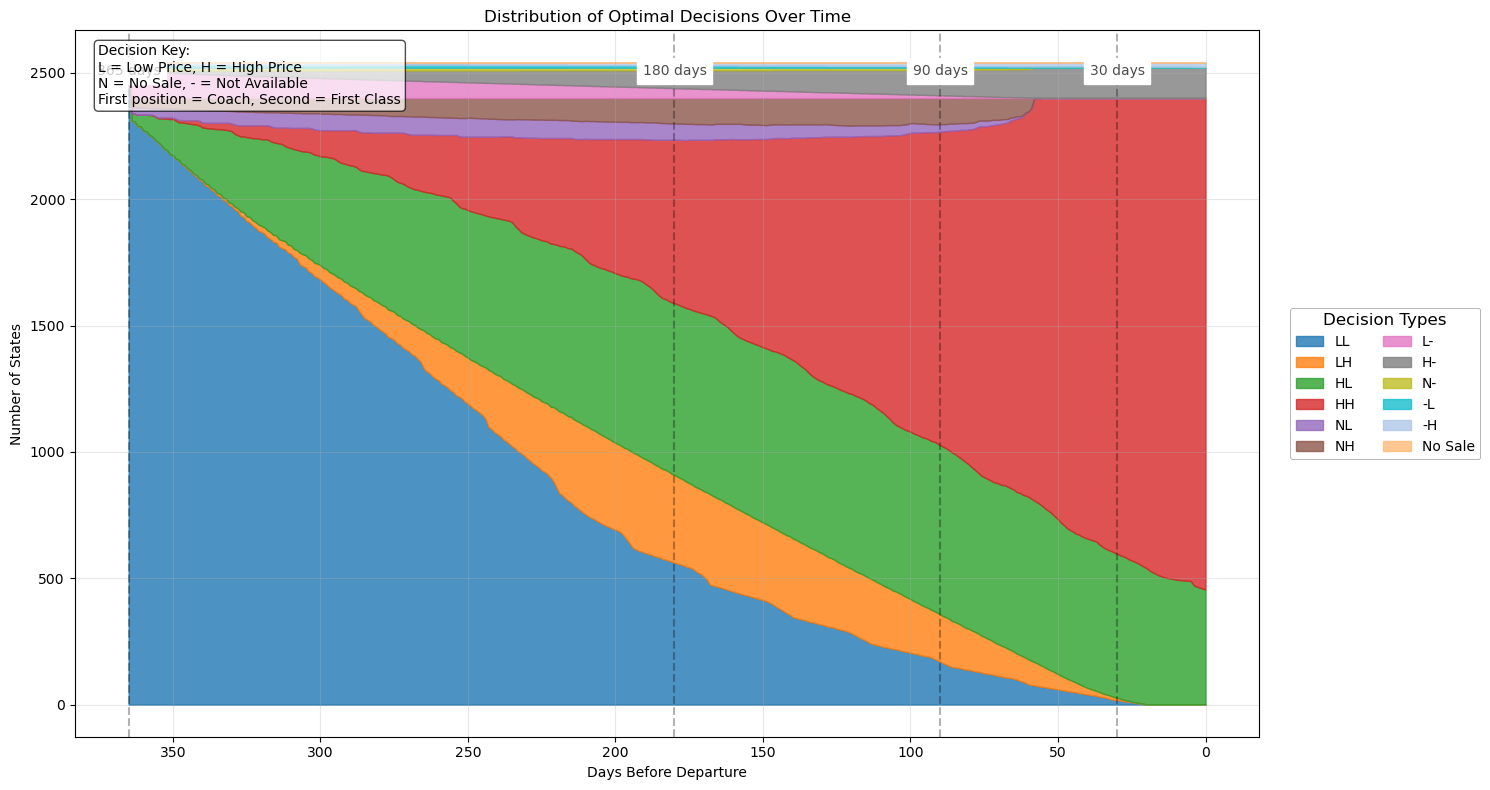

In [17]:
# Determine the best policy
best_idx = np.argmax([profit1, profit2, profit3, profit4])
all_u = [U1, U2, U3, U4]
best_U = all_u[best_idx]

# 1. Create the snapshot visualization
fig1, axes = visualize_u_matrix_over_time(
    best_U, 
    coach_seats=coach_seats,  # Replace with your actual values
    first_class_seats=first_class_seats,  # Replace with your actual values
    allow_no_coach_sale=True,  # Set appropriately for your best policy
    days=days,
    time_steps=6  # Number of time snapshots to show
)

# 2. Display the decision reference table
decision_table = create_decision_explanation_table(allow_no_coach_sale=True)
display(decision_table)

# 3. Create the decision distribution visualization
fig2, ax2 = visualize_decision_distribution(best_U, allow_no_coach_sale=True)

# Save the figures if desired
fig1.savefig('u_matrix_snapshots.png', dpi=300, bbox_inches='tight')
fig2.savefig('decision_distribution.png', dpi=300, bbox_inches='tight')